## [Week3] 모두의 주차장 앱 이용자 별 향후 이용건수 예측
### 주제: 앱 이용자 별 향후 이용 건수 예측 
### 목적: 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
### 모델 개발 요건: 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측 

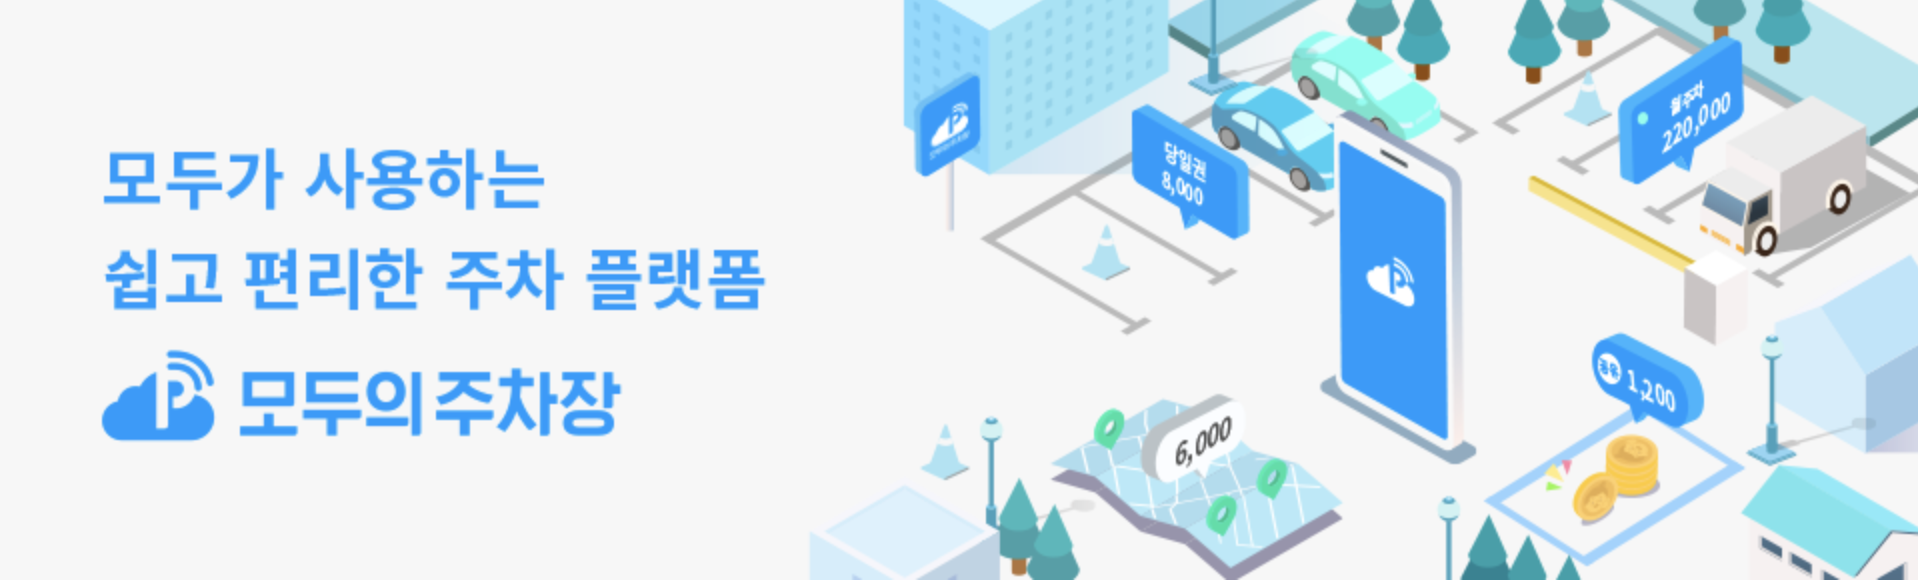

## 모두의 주차장
### 모바일을 통한 위치기반 주차장 정보 안내 및 주차공간 공유 서비스
URL: https://www.moduparking.com/
#### 서비스 출시 : 2013년 8월 서울 시내 2000개의 주차장 정보를 기반으로 출시 
#### 어플 런칭: 2013년 12월 
#### 주차 관련 시스템은 미국보다 우리나라가 발달되어 있지만, 정보가 부족, 정보를 잘 엮어 공유하여 서비스하면 괜찮지 않을까? 하는 아이디어에서 출발 
#### 주차장 정보 안내
- 서울 및 광역시 내 공영/민영/부설주차장 정보 제공
- 유료 주차장의 무료개방 시간을 실시간으로 반영해 안내
- 네비게이션 앱 연동 (Tmap, 네이버 지도, 카카오네비, 원내비, 맵피, 아틀란 3D 지원)
- 무료주차공간 정보 제공

#### 유휴 주차공간 공유
- 거주자 우선 주차, 사무건물, 빌라, 교회 등 주차면의 쓰지 않는 시간을 다른 운전자들에게 공유
- 공유할 시간(요일 및 시간)을 자유롭게 설정 가능
- '21년 2월 기준' 서울시 내 23개, 부산시 8개 자치구, 부천시와 주차공유사업 업무협약 체결

#### 주차요금 결제
- 공유주차장 및 제휴주차장 요금을 모바일로 결제하여 이용 (공영주차장은 제외)

#### 그밖에 정보 
- 2015년 '한국 구글플레이를 빛낸 베스트 앱' 선정
- 2014년 대한민국 인터넷대상 ‘국무총리상' (인터넷 사회진흥부문)
- 2013년 데모데이 '2014년을 빛낸 스타트업 TOP100' 선정
- 2013년 대한민국 모바일 앱어워드 '혁신상' 및 '으뜸앱' 선정
- 2013년 서울시 지정 ‘공유기업' 및 '주차공유 사업 시범 사업자’ 선정

#### Data 정의 
- Input: Tabular 데이터
- 2020.01.01 ~ 2020.12.31
- Output: Regression (향후 이용 건수 예측)

#### Task 정의
- Regression, 유저별 한 달후 이용 건수 예측 

#### Metric 정의
- MSE(평균제곱오차), MAE(평균절대오차)

#### 데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터

## 1. 데이터 살펴보기 
### 1-1. 패키지 및 데이터 불러오기 

In [1]:
# 패키지 import 
import pandas as pd
import numpy as np

# 그래프 관련 패키지 import 
import matplotlib.pyplot as plt  # mpatplotlib.pyplot
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates #  그래프의 원하는 날짜 형식으로 포멧 셋팅 Matplotlib.dates
import matplotlib.animation as animation # 그래프 애니메이션 효과 셋팅 Matplotlib.animation
import missingno as msno # 결측치 그래프 확인 missingno 패키지

import seaborn as sns
sns.set_style('darkgrid') # seaborn 그래프 background 회색으로 설정 
sns.set_context('talk') # 컨텍스트 매개 변수를 변경 플롯의 레이블에 대한 기본 글꼴 크기를 제어하는데 사용
sns.set(font_scale = 1)

import plotly.express as px # plotly.express
import plotly.io as pio # plotly 라이브러리를 표기하기 위해 추가한 코드 
pio.renderers.default = "notebook_connected"


# 모델링 관련 패키지 import 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings   # 버전 충돌로 나오는 경고 표시를 표시하지 않게 설정 
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc   
# plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

In [2]:
# 주 데이터 - 실전 데이터 DB 
df_db = pd.read_csv('data/실전db.csv')
df_db.head(5)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [3]:
df_db.describe()

,USER_ID,STORE_ID,COUNT
count,8.792710e+05,879271.000000,879271.000000
mean,1.206566e+06,149599.960642,1.029079
std,4.206529e+05,68898.035318,0.512428
min,2.240000e+02,4.000000,1.000000
25%,9.005760e+05,92437.000000,1.000000
50%,1.321440e+06,173059.000000,1.000000
75%,1.542416e+06,220661.000000,1.000000
max,1.830598e+06,231465.000000,61.000000


In [4]:
# 실전 데이터 DB 데이터 타입 확인 
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [5]:
# 실전DB 사이즈 확인
df_db.shape

(879271, 8)

In [6]:
# 외부 데이터 1 - 2020년 교통량 데이터
trafic = pd.read_excel('data/2020교통량통합.xlsx')
trafic.head(5)

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [7]:
# 교통량 통합 데이터 타입 확인 
trafic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [8]:
# 교통량 통합 데이터 타입 확인 
trafic.shape

(98820, 29)

In [9]:
# 외부 데이터 2 - 서울 기상 데이터 
weather = pd.read_csv('data/서울시_기상데이터.csv', encoding = 'cp949')
weather.head(5)

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


In [10]:
# 서울시 기상 데이터 타입
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점      8760 non-null   int64  
 1   일시      8760 non-null   object 
 2   기온      8759 non-null   float64
 3   강수량     1059 non-null   float64
 4   풍속      8760 non-null   float64
 5   습도      8760 non-null   int64  
 6   일조시간    4791 non-null   float64
 7   적설량     208 non-null    float64
 8   지면온도    8752 non-null   float64
 9   지중온도    8748 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 684.5+ KB


In [11]:
# 서울시 기상 데이터 사이즈 
weather.shape

(8760, 10)

### 1-2. 결측치 살펴보기
- 우선 주 데이터인 **실전 DB** 데이터를 기준으로 살펴보기 

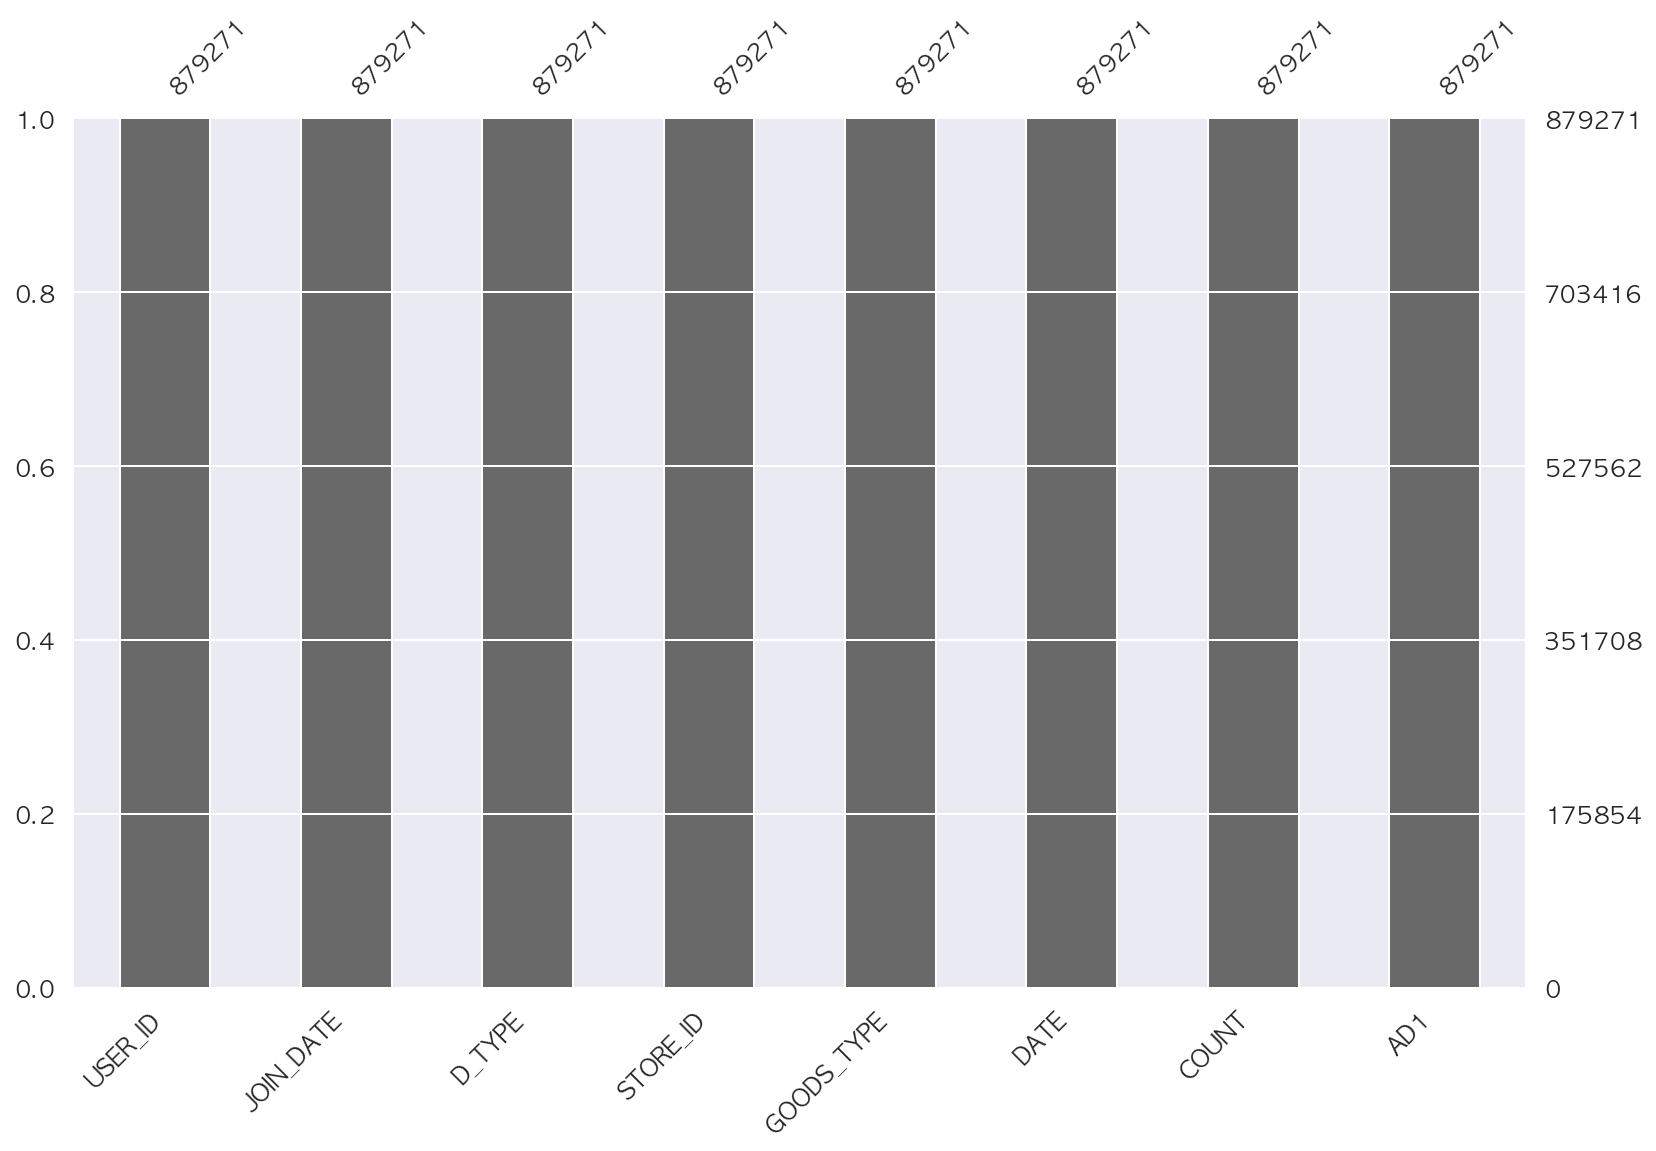

In [12]:
# 결측치 그래프 나타내기
msno.bar(df_db, fontsize=12, figsize=(13,8));

In [13]:
# 결측치 확인하기
for i in df_db.columns:
    ab = df_db[i].isnull().sum()
    if ab < 100000:
        print(i + "has {} null values.".format(ab))
        print()

USER_IDhas 0 null values.

JOIN_DATEhas 0 null values.

D_TYPEhas 0 null values.

STORE_IDhas 0 null values.

GOODS_TYPEhas 0 null values.

DATEhas 0 null values.

COUNThas 0 null values.

AD1has 0 null values.



- 결측치 확인결과 결측치가 없는 깨끗한 데이터 임을 확인 

### 1-3. 컬럼 정보
#### 컬럼의 정보는 다음과 같다 
1. USER_ID: 유저 ID
2. JOIN_DATE: 가입 일자 
3. D_TYPE:
4. STORE_ID: 점포 ID 
5. GOODS_TYPE: 
6. DATE: 결제일
7. COUNT: 결제건수  
8. AD1

#### 컬럼의 정보가 명확하지 않은 것이 D_TYPE, GOODS_TYPE, AD1 이다. 해당 컬럼의 정보는 EDA를 통해 알아보고자 한다.

### 1-4. EDA 전 전처리 
- 데이터를 살펴보니 가입일자, 결제일자가 있음. 
- 다양한 인사이트를 얻기 위해 해당 작업을 진행 
    1. 가입일 데이터를 년, 월, 일 로 나눔 
    2. 결제일 데이터를 년, 월, 일 로 나눔 
    3. 가입일, 결제일, 데이터를 datetime 데이터 형태로 변환
    4. 언제 사용이 많이 일어나는지 알아보기 위해 결제일 기준으로 요일 추가 

In [14]:
# 가입일인 JOIN_DATE 컬럼을 "-"를 기준으로 분할
pay_date_list = df_db['JOIN_DATE'].str.split("-")

# 가입일자의 년도와 월을 생성
df_db['JOIN_YEAR'] = pay_date_list.str.get(0)
df_db['JOIN_MONTH'] = pay_date_list.str.get(1)
df_db['JOIN_DAY'] = pay_date_list.str.get(2)

# 컬럼 재설정 
df_db = df_db[['USER_ID', 'JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'JOIN_DAY', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 
               'DATE', 'COUNT', 'AD1']]

In [15]:
# 결제일인 DATE 컬럼을 "-"를 기준으로 분할
pay_date_list = df_db['DATE'].str.split("-")

# 가입일자의 년도와 월을 생성
df_db['PAY_YEAR'] = pay_date_list.str.get(0)
df_db['PAY_MONTH'] = pay_date_list.str.get(1)
df_db['PAY_DAY'] = pay_date_list.str.get(2)

# 컬럼 재설정 
df_db = df_db[['USER_ID', 'JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'JOIN_DAY', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 
               'DATE', 'PAY_YEAR', 'PAY_MONTH', 'PAY_DAY', 'COUNT', 'AD1']]

In [16]:
# Date를 Datetime으로 년, 월, 일로 나눠진 문자열 데이터를 숫자형으로 변환
df_db.JOIN_DATE = pd.to_datetime(df_db.JOIN_DATE)
df_db.JOIN_YEAR = pd.to_numeric(df_db.JOIN_YEAR)
df_db.JOIN_MONTH = pd.to_numeric(df_db.JOIN_MONTH)
df_db.JOIN_DAY = pd.to_numeric(df_db.JOIN_DAY)
df_db.DATE = pd.to_datetime(df_db.DATE)
df_db.PAY_YEAR = pd.to_numeric(df_db.PAY_YEAR)
df_db.PAY_MONTH = pd.to_numeric(df_db.PAY_MONTH)
df_db.PAY_DAY = pd.to_numeric(df_db.PAY_DAY)

In [17]:
# 요일 데이터 "WEEKDAY"라는 컬럼을 추가 
df_db["WEEKDAY"] = df_db["DATE"].dt.strftime("%a")

# 컬럼 재설정 
df_db = df_db[['USER_ID', 'JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'JOIN_DAY', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 
               'DATE', 'PAY_YEAR', 'PAY_MONTH', 'PAY_DAY', 'WEEKDAY', 'COUNT', 'AD1']]

In [18]:
# 전처리한 데이터 확인 
df_db.head(5)

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,JOIN_DAY,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,PAY_DAY,WEEKDAY,COUNT,AD1
0,2858,2014-01-07,2014,1,7,AA,1892,A,2020-01-01,2020,1,1,Wed,1,GN
1,5647,2014-02-14,2014,2,14,BB,182009,A,2020-01-01,2020,1,1,Wed,1,J
2,33314,2014-11-20,2014,11,20,BB,82431,A,2020-01-01,2020,1,1,Wed,1,SC
3,37001,2014-12-04,2014,12,4,BB,725,C,2020-01-01,2020,1,1,Wed,1,MP
4,37819,2014-12-07,2014,12,7,AA,220691,C,2020-01-01,2020,1,1,Wed,1,JRR


In [19]:
# 데이터 타입 확인 
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   JOIN_YEAR   879271 non-null  int64         
 3   JOIN_MONTH  879271 non-null  int64         
 4   JOIN_DAY    879271 non-null  int64         
 5   D_TYPE      879271 non-null  object        
 6   STORE_ID    879271 non-null  int64         
 7   GOODS_TYPE  879271 non-null  object        
 8   DATE        879271 non-null  datetime64[ns]
 9   PAY_YEAR    879271 non-null  int64         
 10  PAY_MONTH   879271 non-null  int64         
 11  PAY_DAY     879271 non-null  int64         
 12  WEEKDAY     879271 non-null  object        
 13  COUNT       879271 non-null  int64         
 14  AD1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(9), object(4)
memory us

In [20]:
# 각 column당 row 값 현황 정리 - unique
for col in df_db.columns:
    print(f"column : {col}")
    print(f"The number of unique : {df_db[col].nunique()}")  # nunique: 유니크한 value의 갯수를 나타내는 함수
    print()

column : USER_ID
The number of unique : 165425

column : JOIN_DATE
The number of unique : 2352

column : JOIN_YEAR
The number of unique : 9

column : JOIN_MONTH
The number of unique : 12

column : JOIN_DAY
The number of unique : 31

column : D_TYPE
The number of unique : 3

column : STORE_ID
The number of unique : 1061

column : GOODS_TYPE
The number of unique : 4

column : DATE
The number of unique : 366

column : PAY_YEAR
The number of unique : 1

column : PAY_MONTH
The number of unique : 12

column : PAY_DAY
The number of unique : 31

column : WEEKDAY
The number of unique : 7

column : COUNT
The number of unique : 56

column : AD1
The number of unique : 85



## 2. EDA 1 - 데이터 각 컬럼의 의미 탐색 

### 2-1. 가입일자 

In [21]:
df_db['JOIN_YEAR'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 1970, 2020, 2013])

In [22]:
# 가입 발생한 년도별 건수 분포 
year_1970_count = len(df_db[df_db['JOIN_YEAR']==1970])
year_2013_count = len(df_db[df_db['JOIN_YEAR']==2013])
year_2014_count = len(df_db[df_db['JOIN_YEAR']==2014])
year_2015_count = len(df_db[df_db['JOIN_YEAR']==2015])
year_2016_count = len(df_db[df_db['JOIN_YEAR']==2016])
year_2017_count = len(df_db[df_db['JOIN_YEAR']==2017])
year_2018_count = len(df_db[df_db['JOIN_YEAR']==2018])
year_2019_count = len(df_db[df_db['JOIN_YEAR']==2019])
year_2020_count = len(df_db[df_db['JOIN_YEAR']==2020])

print('1970년 기준 건수:', year_1970_count, '건')
print('2013년 기준 건수:', year_2013_count, '건')
print('2014년 기준 건수:', year_2014_count, '건')
print('2015년 기준 건수:', year_2015_count, '건')
print('2016년 기준 건수:', year_2016_count, '건')
print('2017년 기준 건수:', year_2017_count, '건')
print('2018년 기준 건수:', year_2018_count, '건')
print('2019년 기준 건수:', year_2019_count, '건')

1970년 기준 건수: 1093 건
2013년 기준 건수: 37 건
2014년 기준 건수: 2957 건
2015년 기준 건수: 14946 건
2016년 기준 건수: 32701 건
2017년 기준 건수: 79938 건
2018년 기준 건수: 140523 건
2019년 기준 건수: 257603 건


- 가입일은 2013년도 ~ 2020년도의 기간이 확인됨 (참고로 모두의 주차장 앱 런칭일이 2013년 12월)
- 그런데 가입년도와 동떨어져 보이는 1970년도의 데이터가 존재함

In [23]:
# 가입년도 1970년도만 추출 
df_db[df_db['JOIN_YEAR']==1970].head(5)

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,JOIN_DAY,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,PAY_DAY,WEEKDAY,COUNT,AD1
437,1081430,1970-01-01,1970,1,1,CC,90070,A,2020-01-01,2020,1,1,Wed,1,GD
2196,1410151,1970-01-01,1970,1,1,CC,92437,B,2020-01-02,2020,1,2,Thu,1,J
2204,1415023,1970-01-01,1970,1,1,CC,131081,A,2020-01-02,2020,1,2,Thu,1,YO
2434,125582,1970-01-01,1970,1,1,CC,91885,A,2020-01-03,2020,1,3,Fri,1,YD
2645,602188,1970-01-01,1970,1,1,CC,2334,B,2020-01-03,2020,1,3,Fri,1,MP


- 데이터를 살펴보니 가입일자가 모두 1970년 1월 1월로 나온다.
- 2013년도에 서비스 시작전 데이터라고 보기에는 데이터가 정확하지가 않다.

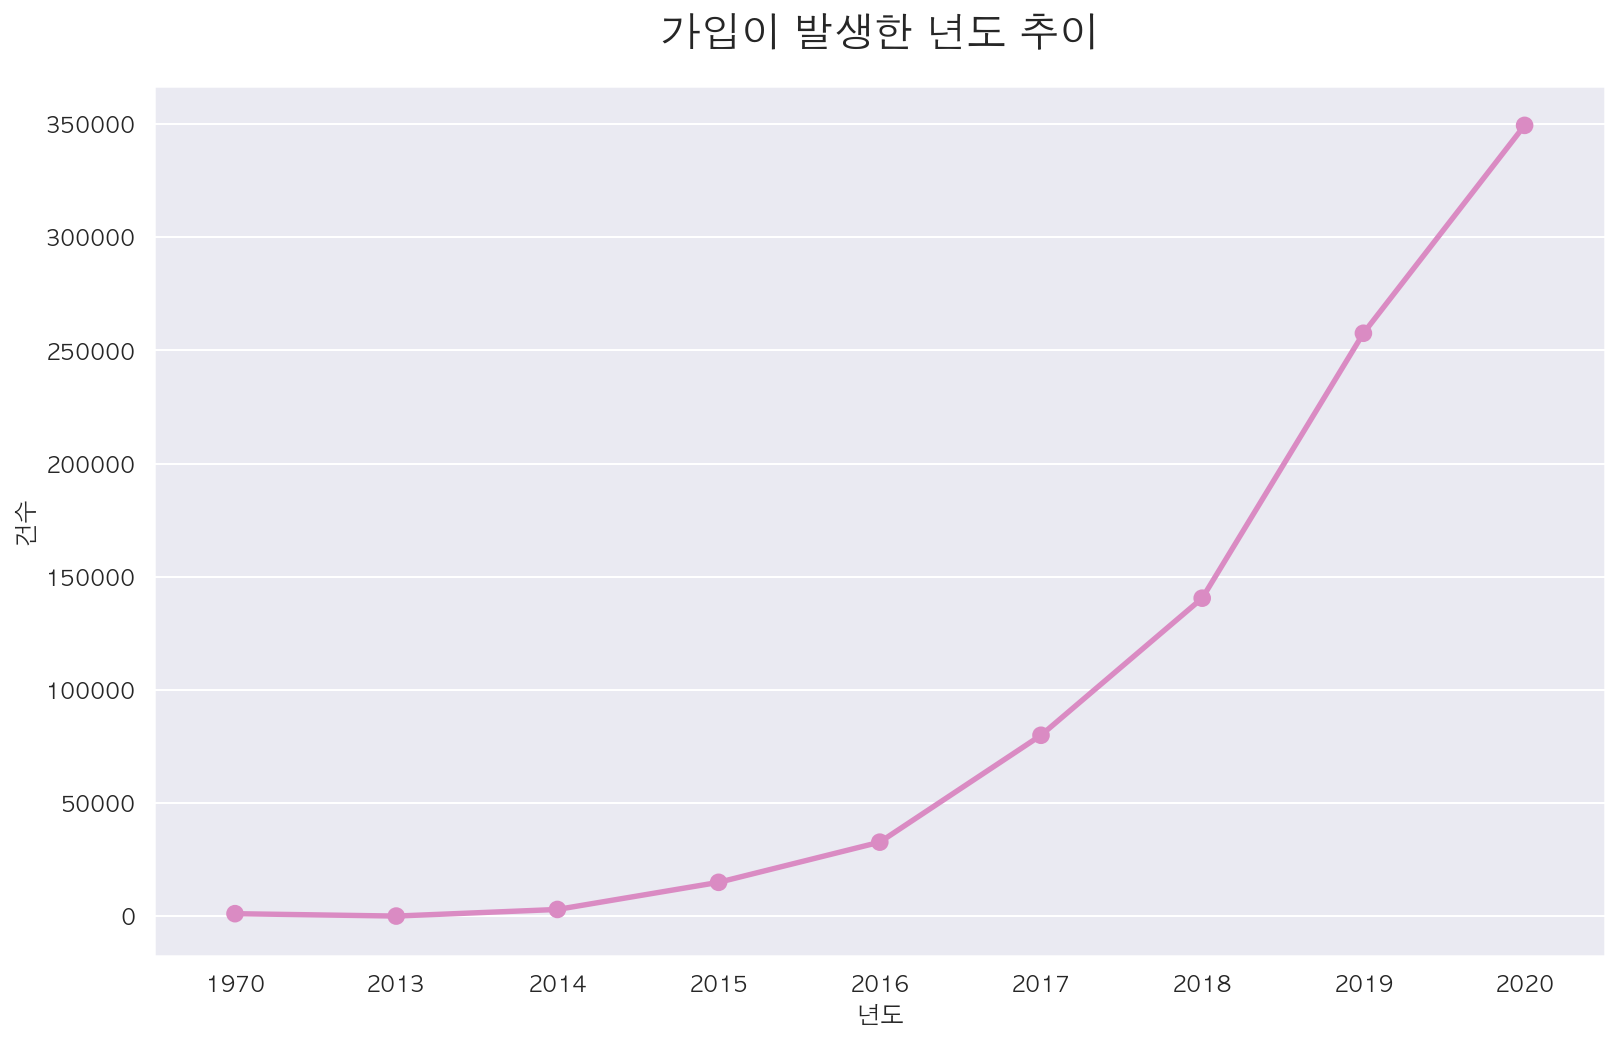

In [24]:
# 그래프로 나타내보기
df_year = pd.DataFrame({'year': [1970, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
                       'case': [1093, 37, 2957, 14946, 32701, 79938, 140523, 257603, 349473],
                       })

plt.figure(figsize=[13,8])
sns.pointplot(data=df_year, x='year', y="case", color=sns.color_palette()[6])
plt.title("가입이 발생한 년도 추이", fontsize=20, pad=20)
plt.xlabel('년도')
plt.ylabel('건수')
plt.show()

- 가입일자와 맞지 않는 1970 데이터는 제거하기로 결정 (회의 결과)
- 가입율은 해마다 증가함을 알 수 있다. (그래프가 일정히 우상향함을 알 수 있음)
- 참고로 특히 2016년도에서 2017년도의 가입율이 144%로 증가폭이 가장 높다.

In [25]:
# 월별 가입자를 알아보기 위해 각 녀도별로 데이터를 나눔 
join_2013 =  df_db[df_db.JOIN_YEAR == 2013] 
join_2014 =  df_db[df_db.JOIN_YEAR == 2014]
join_2015 =  df_db[df_db.JOIN_YEAR == 2015]
join_2016 =  df_db[df_db.JOIN_YEAR == 2016]
join_2017 =  df_db[df_db.JOIN_YEAR == 2017]
join_2018 =  df_db[df_db.JOIN_YEAR == 2018]
join_2019 =  df_db[df_db.JOIN_YEAR == 2019]
join_2020 =  df_db[df_db.JOIN_YEAR == 2020]

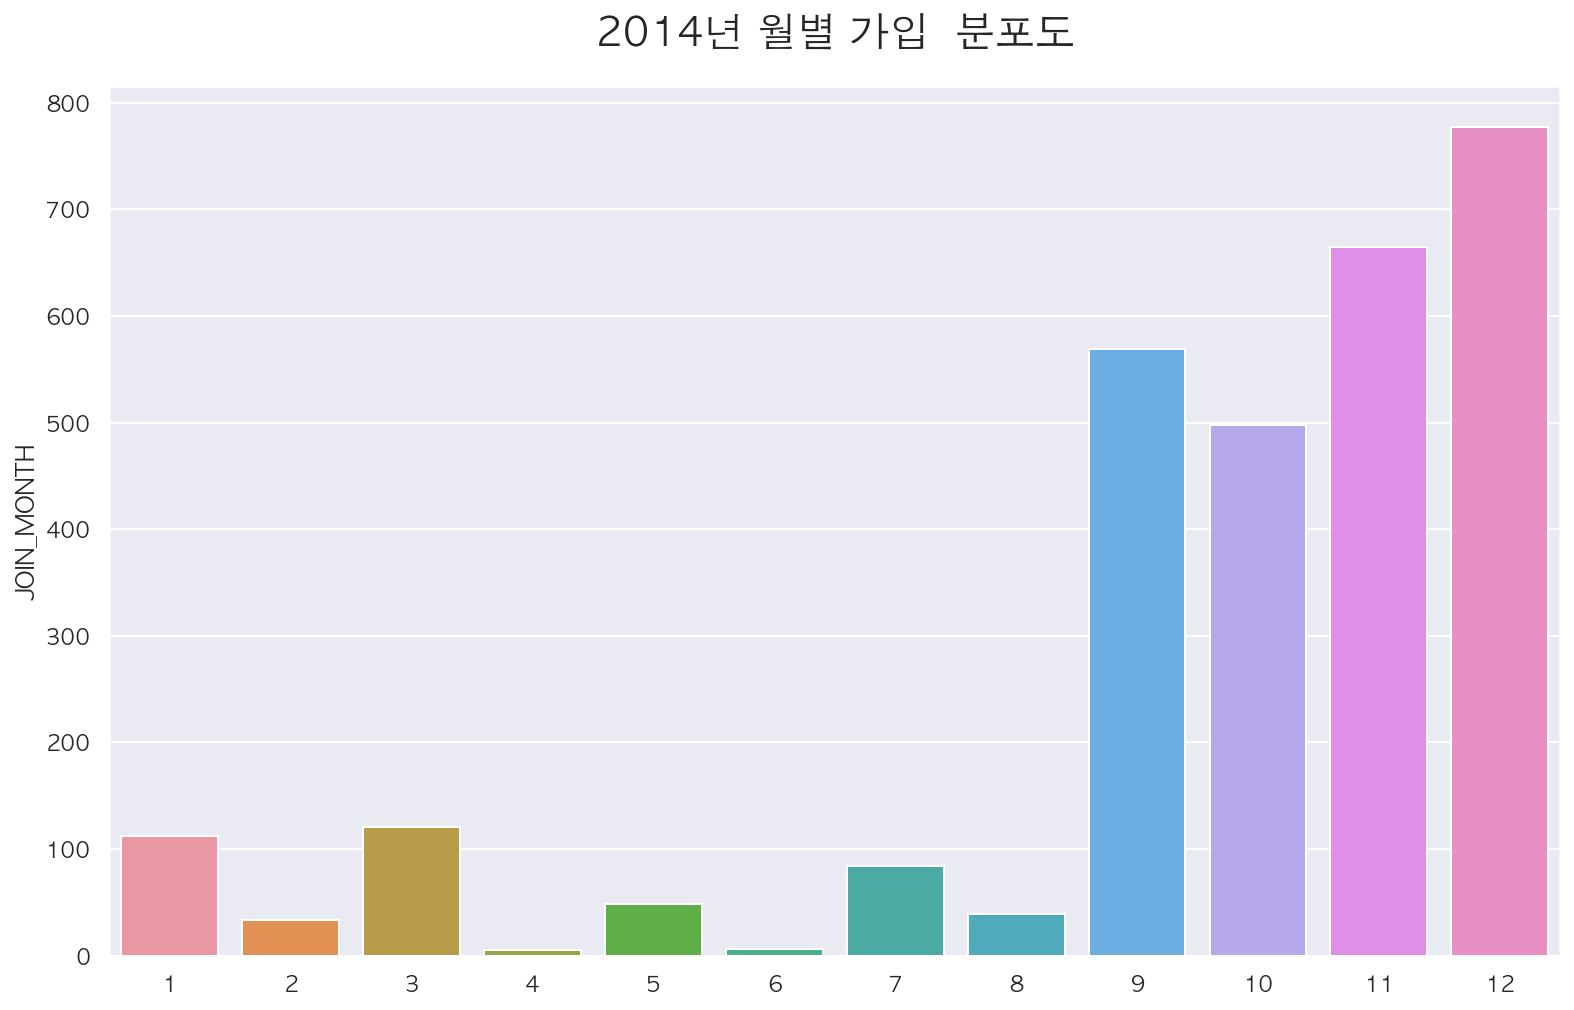

In [26]:
# 2014년도 월별 가입 분포 - 참고로 2013년도는 12월 데이터만 있어 데이터는 제외 
join_2014_month = pd.DataFrame(join_2014['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2014년 월별 가입  분포도", fontsize=20, pad=20)
sns.barplot(data=join_2014_month, x=join_2014_month.index, y="JOIN_MONTH")
plt.show()

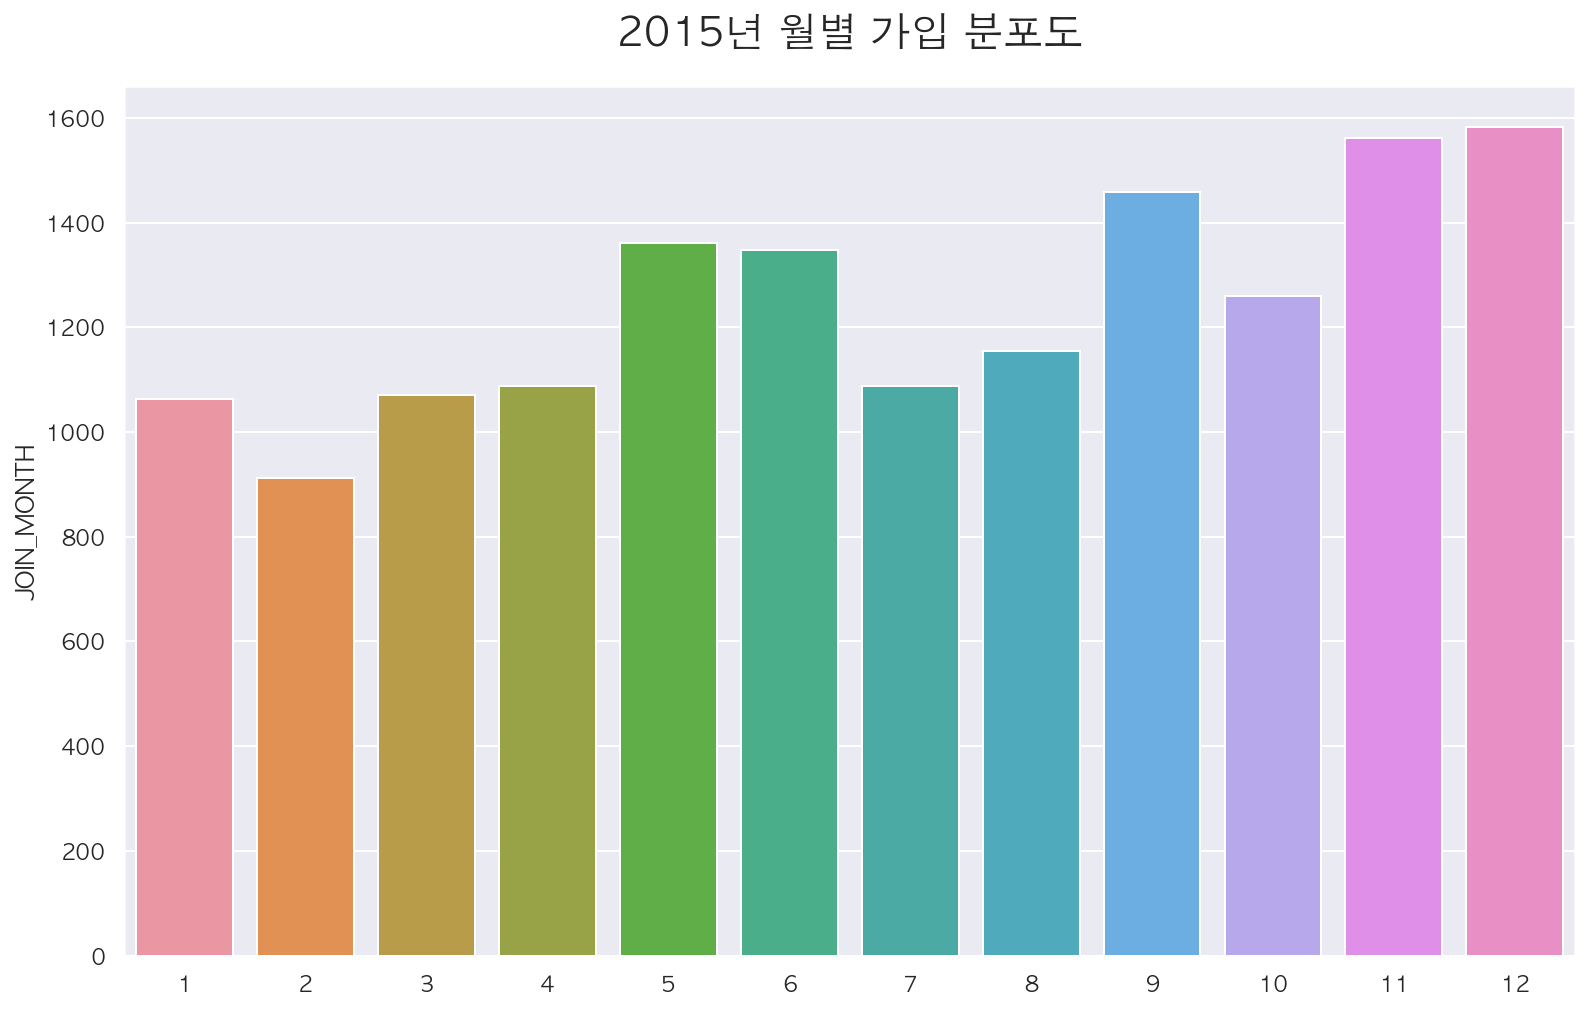

In [27]:
# 2015년도 월별 가입 분포 
join_2015_month = pd.DataFrame(join_2015['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2015년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2015_month, x=join_2015_month.index, y="JOIN_MONTH")
plt.show()

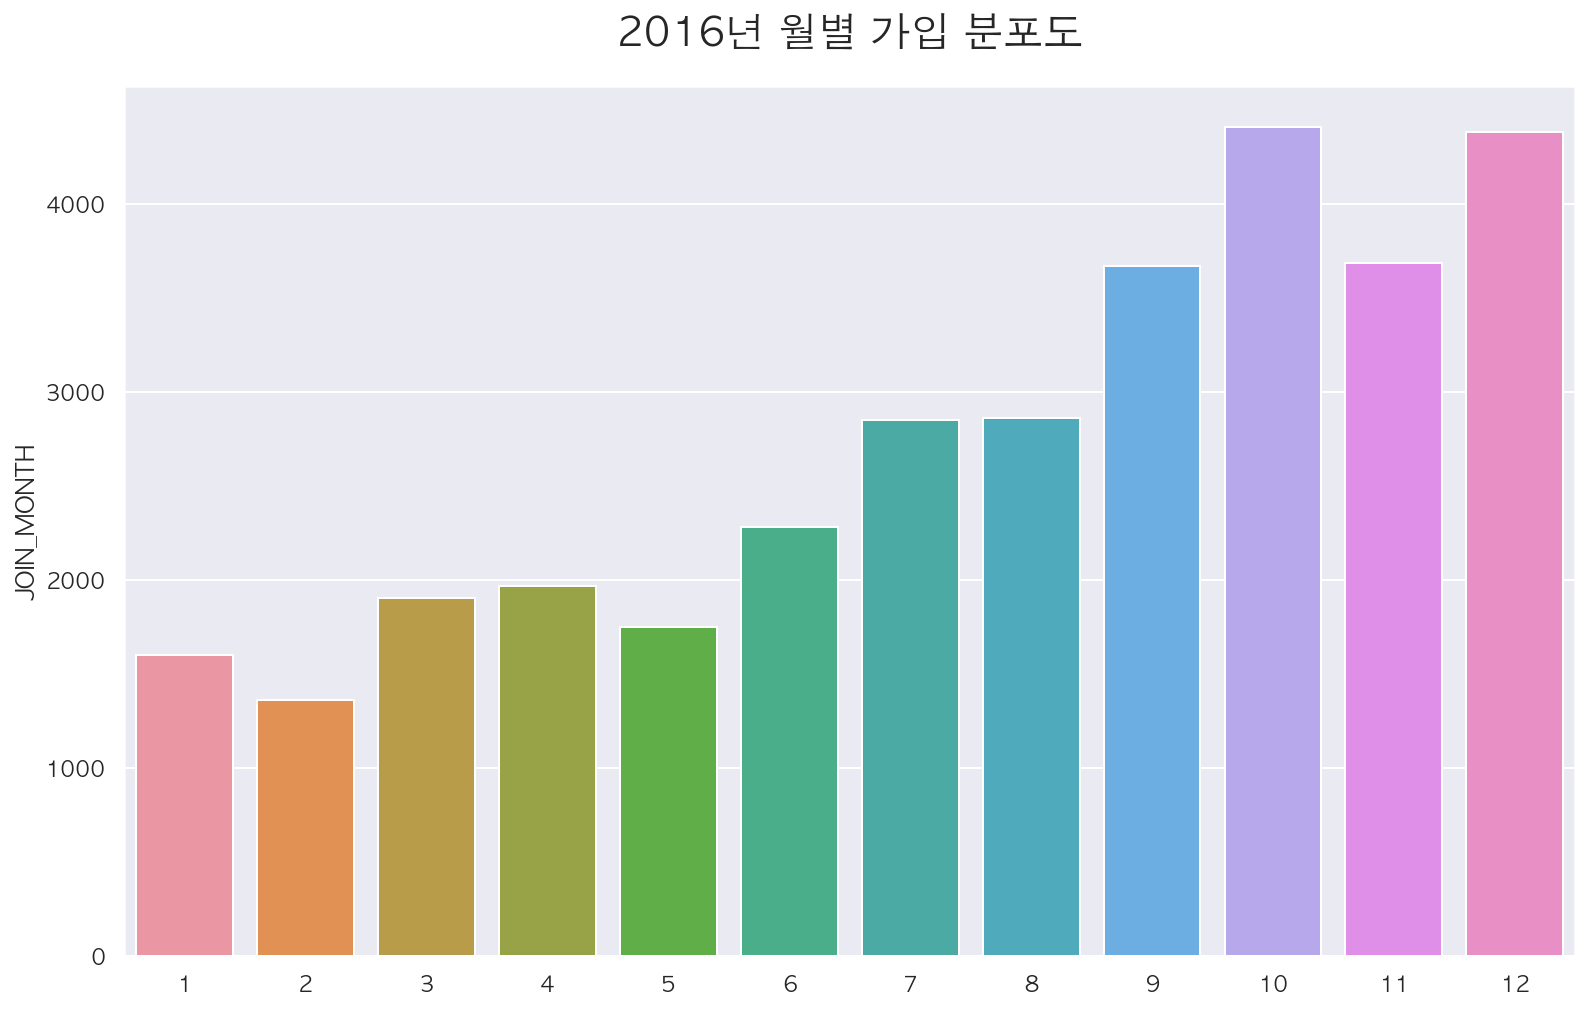

In [28]:
# 2016년도 월별 가입 분포 
join_2016_month = pd.DataFrame(join_2016['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2016년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2016_month, x=join_2016_month.index, y="JOIN_MONTH")
plt.show()

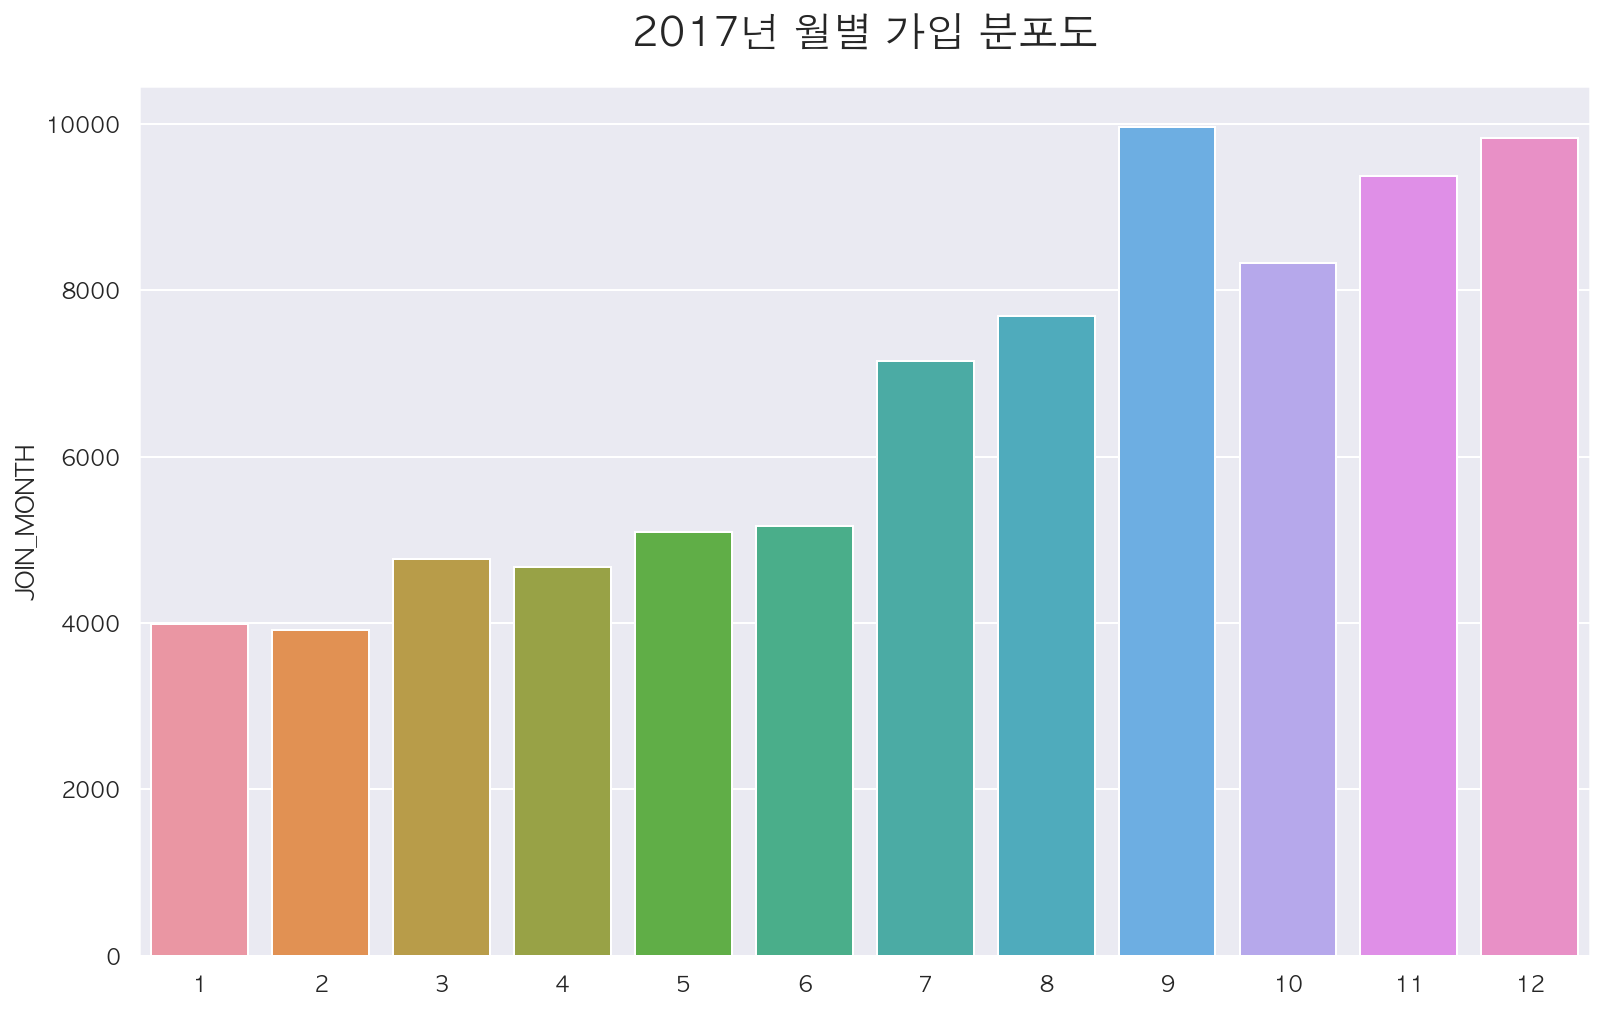

In [29]:
# 2017년도 월별 가입 분포 
join_2017_month = pd.DataFrame(join_2017['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2017년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2017_month, x=join_2017_month.index, y="JOIN_MONTH")
plt.show()

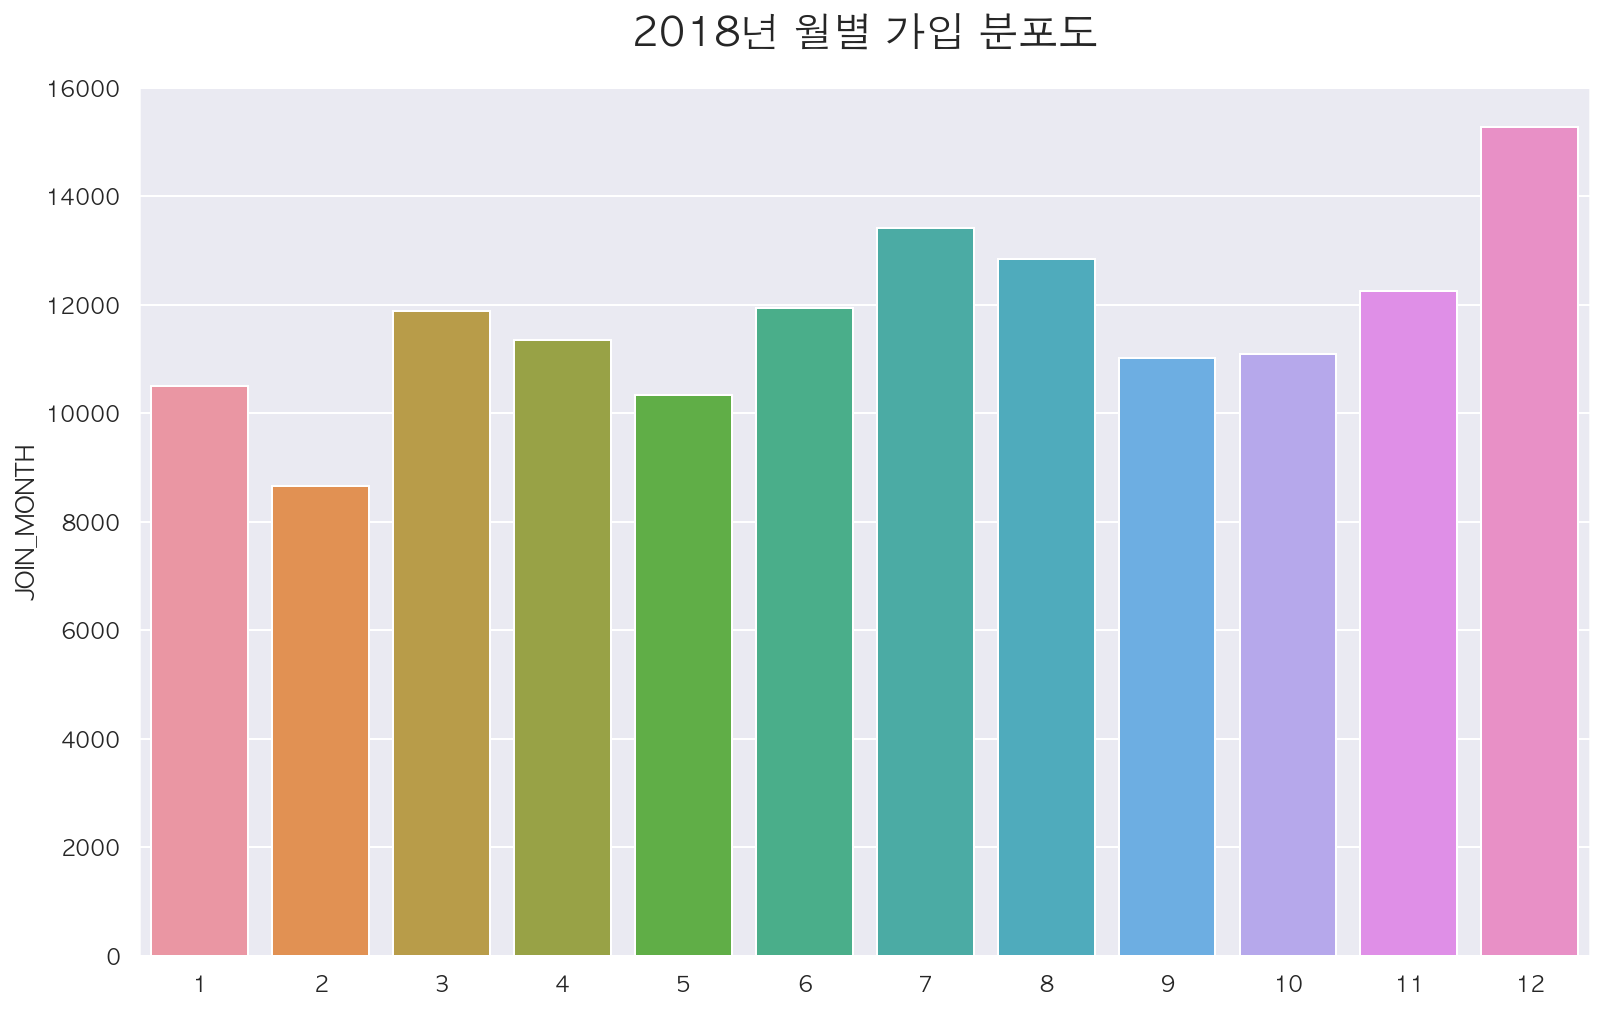

In [30]:
# 2018년도 월별 가입 분포 
join_2018_month = pd.DataFrame(join_2018['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2018년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2018_month, x=join_2018_month.index, y="JOIN_MONTH")
plt.show()

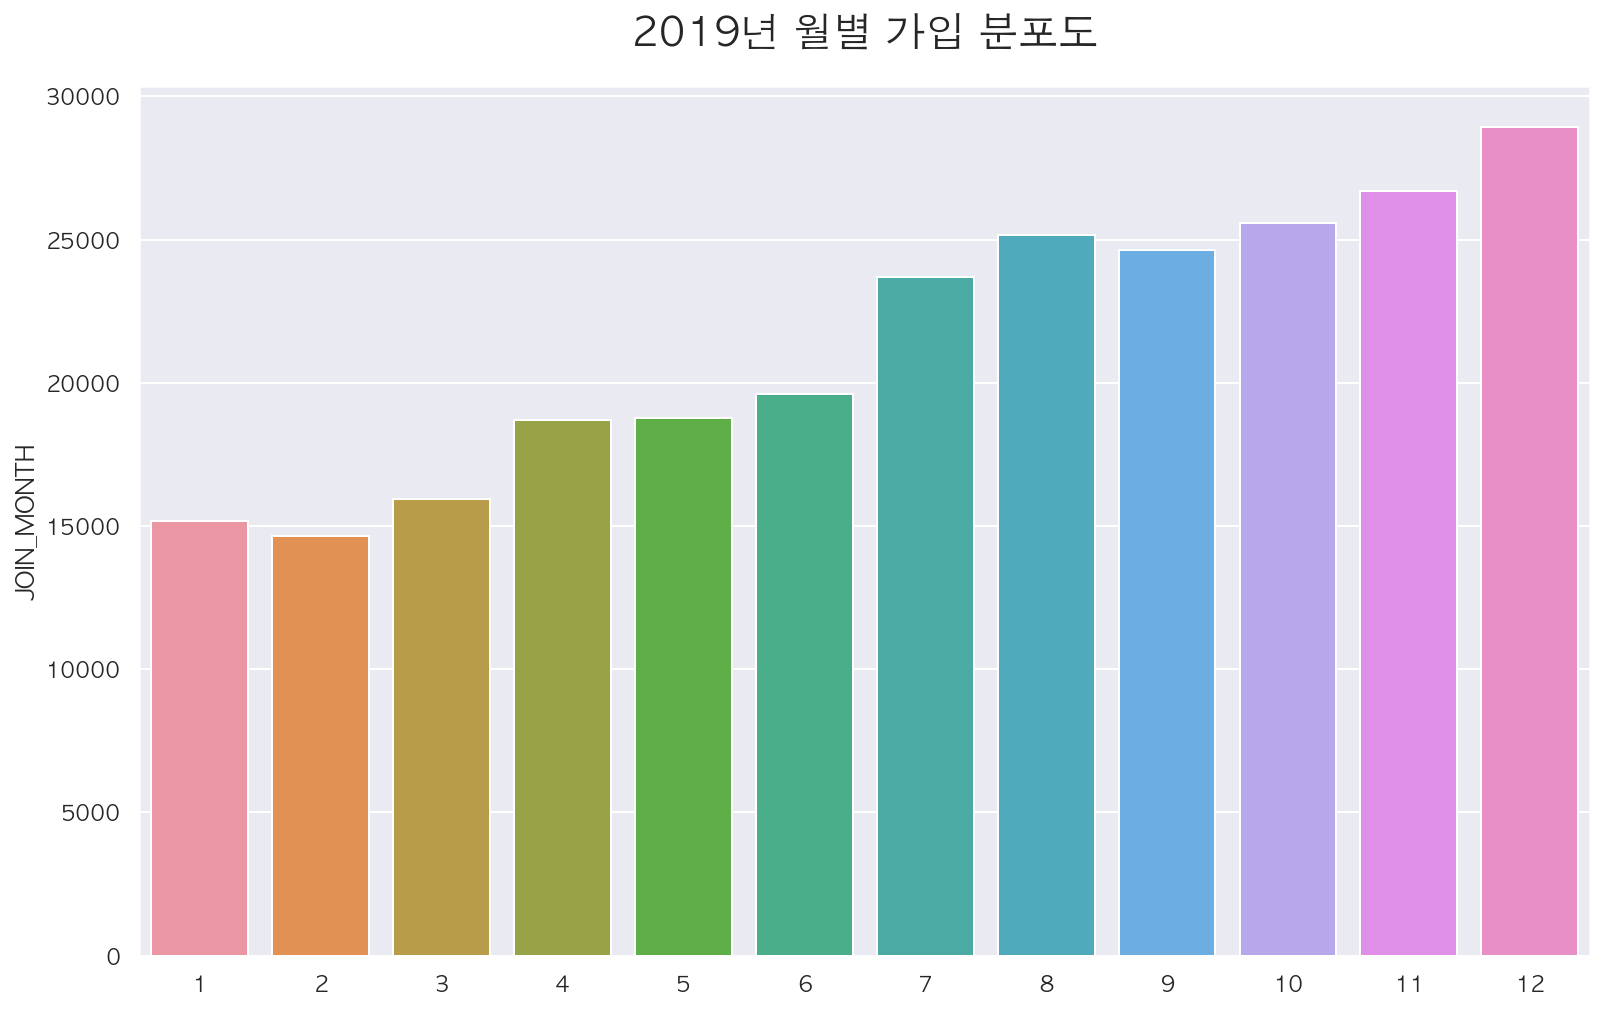

In [31]:
# 2019년도 월별 가입 분포 
join_2019_month = pd.DataFrame(join_2019['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2019년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2019_month, x=join_2019_month.index, y="JOIN_MONTH")
plt.show()

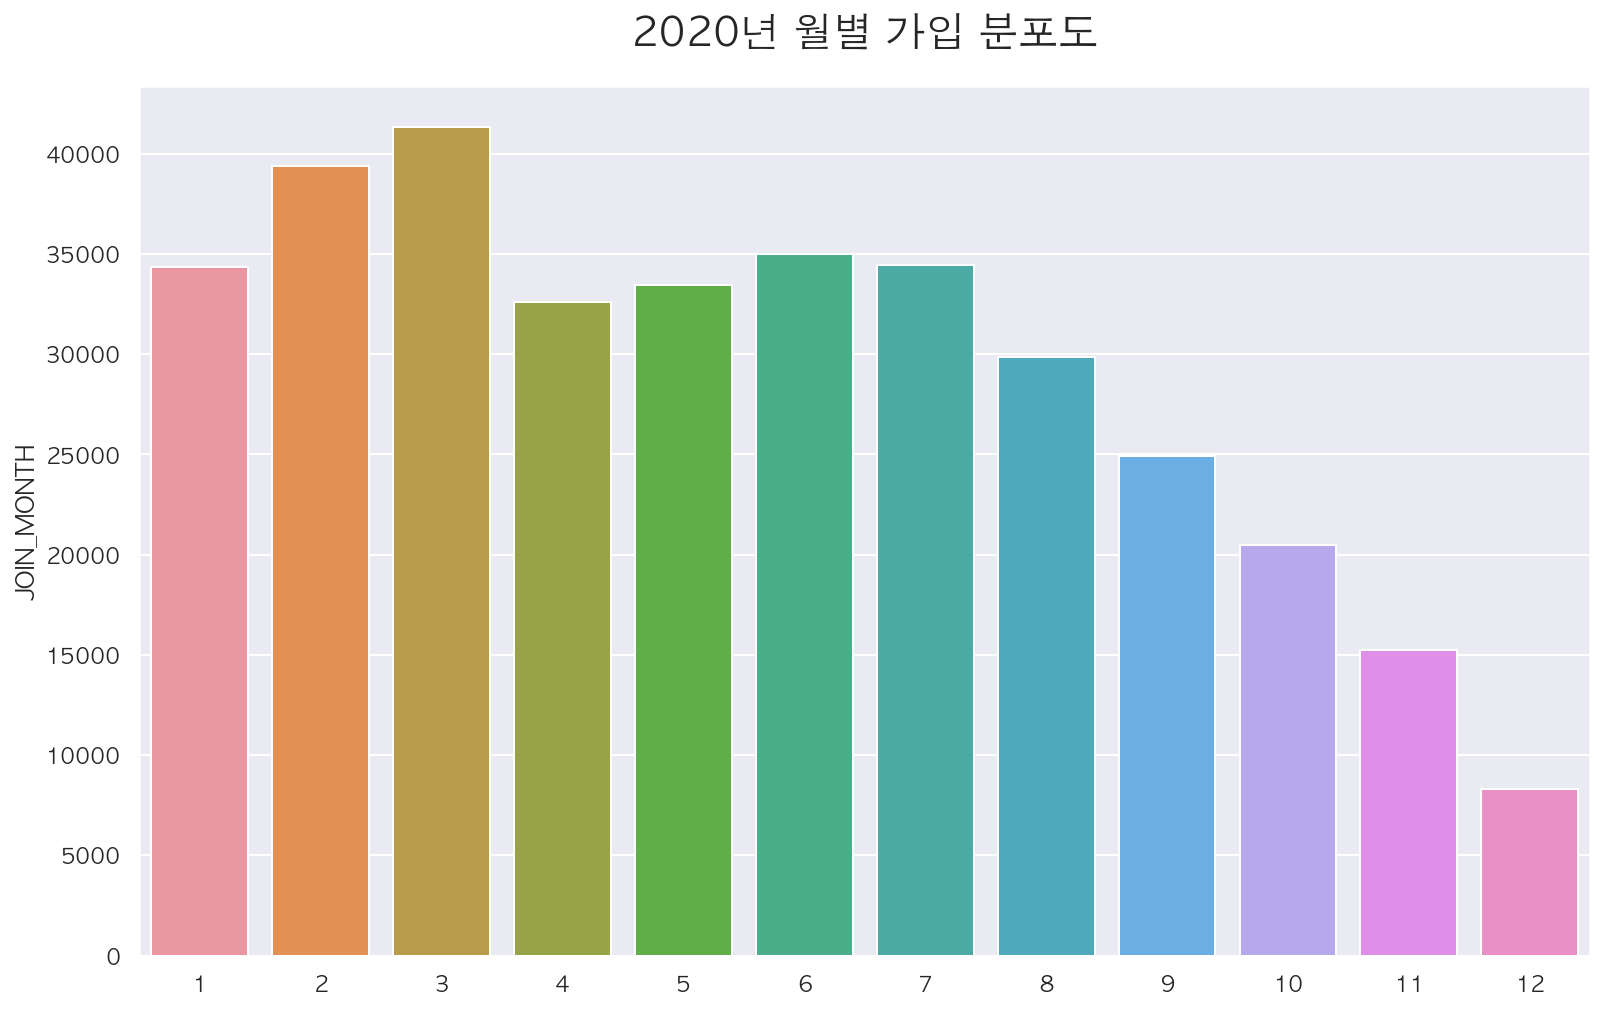

In [32]:
# 2020년도 월별 가입 분포 
join_2020_month = pd.DataFrame(join_2020['JOIN_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2020년 월별 가입 분포도", fontsize=20, pad=20)
sns.barplot(data=join_2020_month, x=join_2020_month.index, y="JOIN_MONTH")
plt.show()

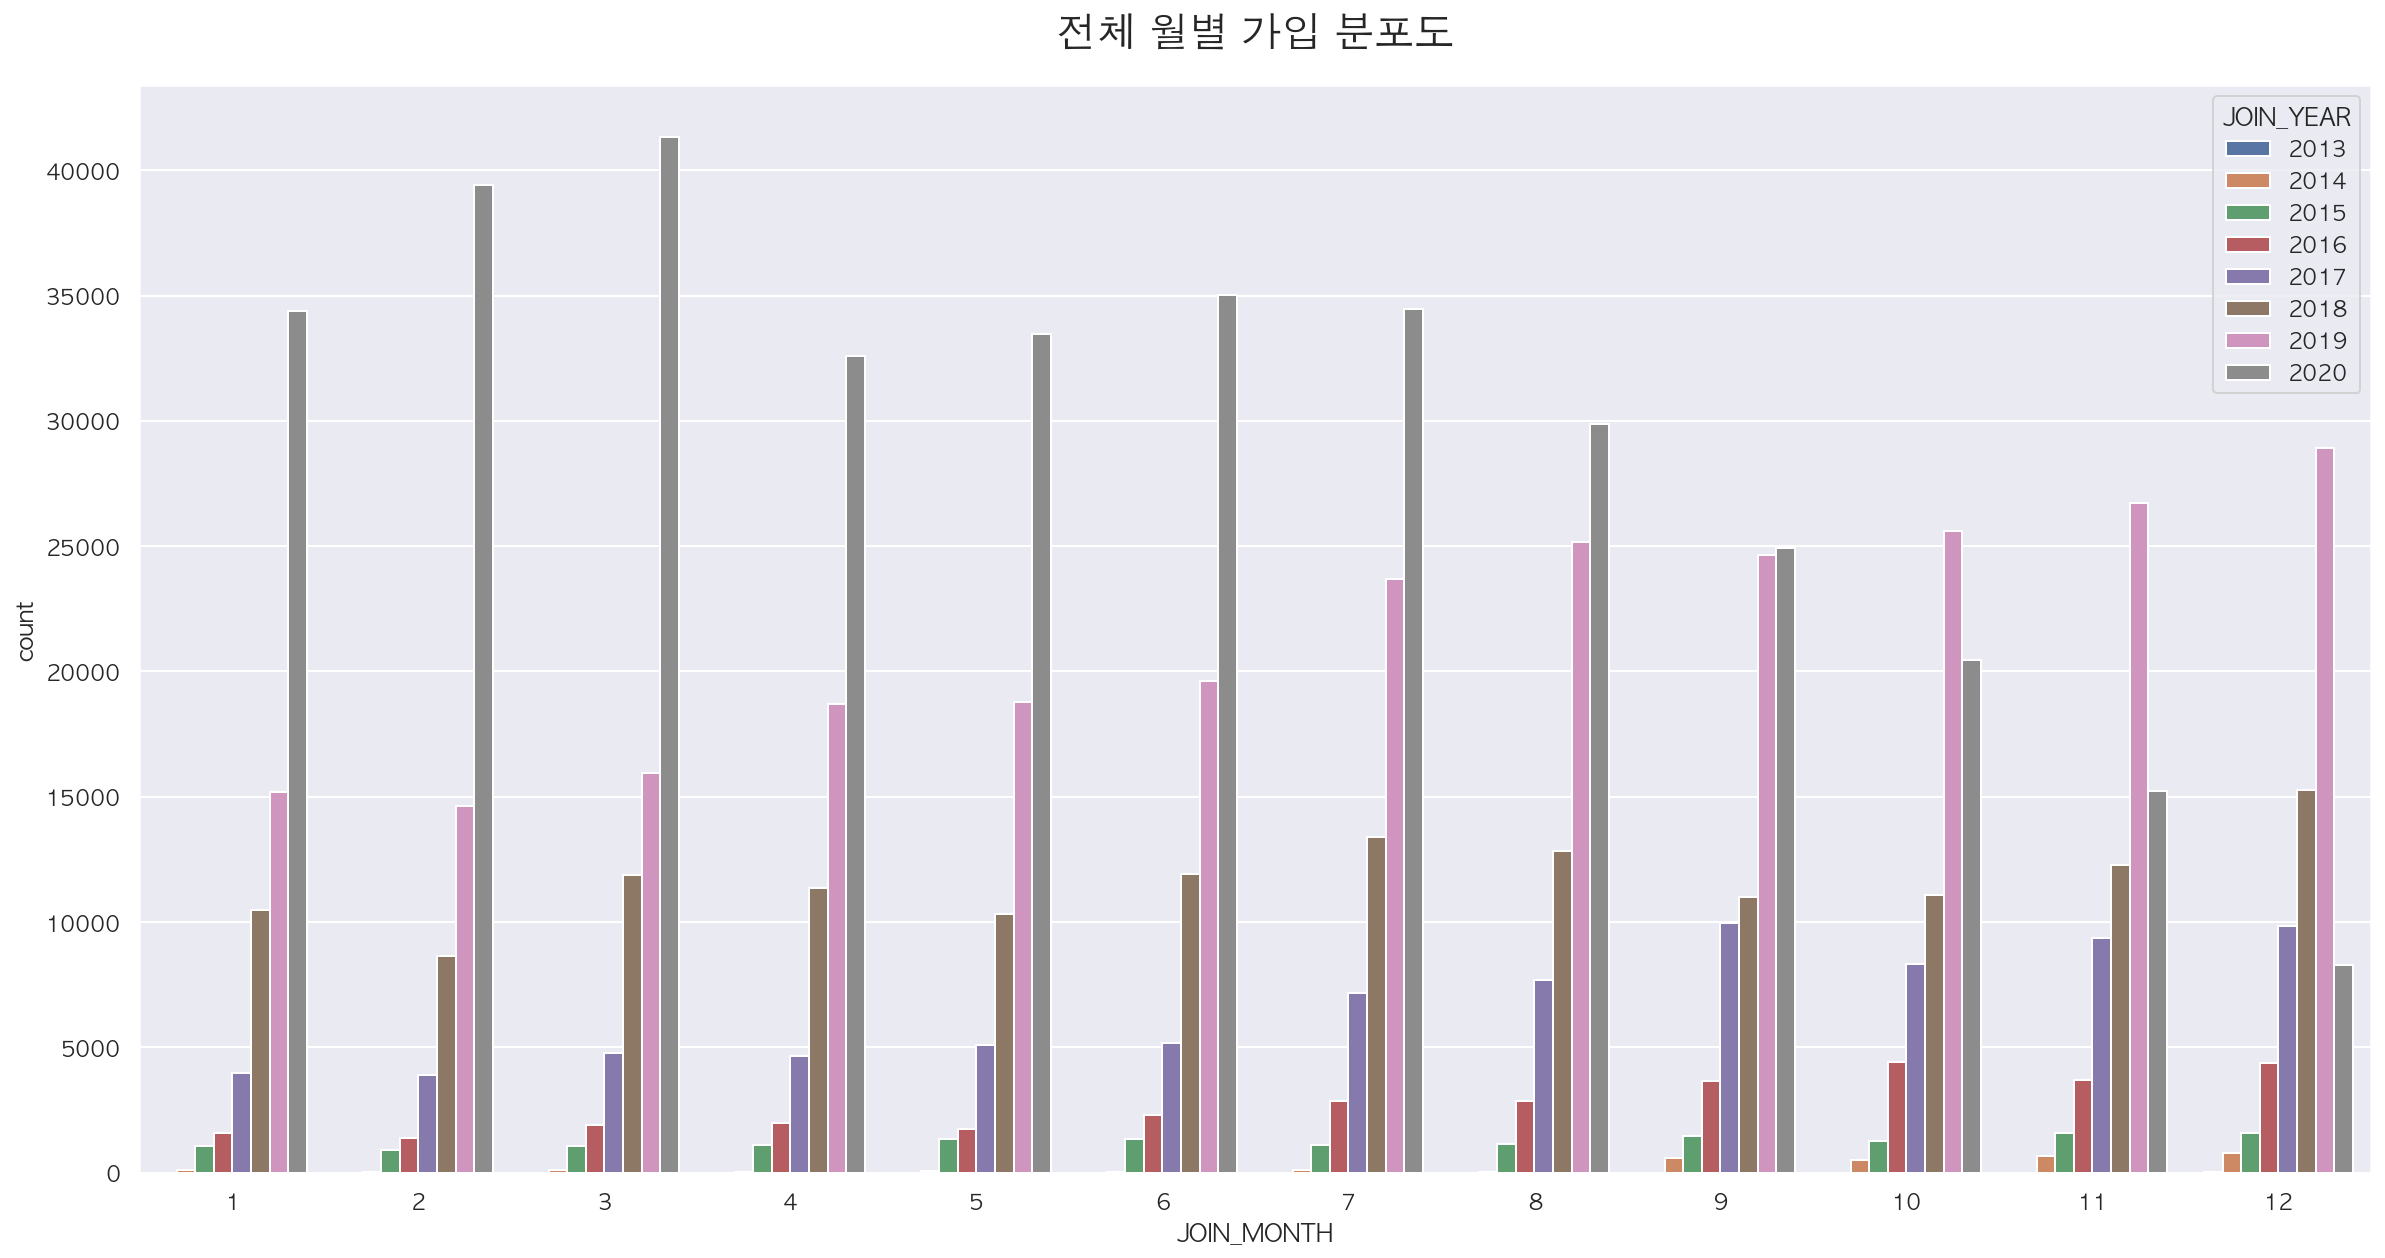

In [33]:
# 전체 그래프
plt.figure(figsize=(20,10))
plt.title("전체 월별 가입 분포도", fontsize=20, pad=20)
sns.countplot(data=df_db, x="JOIN_MONTH", order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              hue="JOIN_YEAR", hue_order=[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
plt.show()

- 월별 가입 현황을 기준으로 가장 가입이 많았던 달은 다음과 같다 
    - 2013년 - 12월
    - 2014년 - 12월
    - 2015년 - 12월
    - 2016년 - 10월
    - 2017년 - 9월
    - 2018년 - 12월
    - 2019년 - 12월
    - 2020년 - 3월 
- 특정한 달에 가장 가입이 많은 것을 알 수 있다.
- 만약 가입한 월별을 비교 분석하고자 할 때 해당 자료를 참고하면 좋을듯 하다.

### 2-2. USER_ID

In [34]:
user_id = pd.DataFrame(df_db['USER_ID'].value_counts())
user_id.head(20)

,USER_ID
999665,366
591610,244
1355841,235
1365069,222
1224426,222
1407916,222
1144500,213
1284291,210
909315,209
1201981,207


In [35]:
print("고유 User ID는", len(user_id),"건 입니다.")

고유 User ID는 165425 건 입니다.


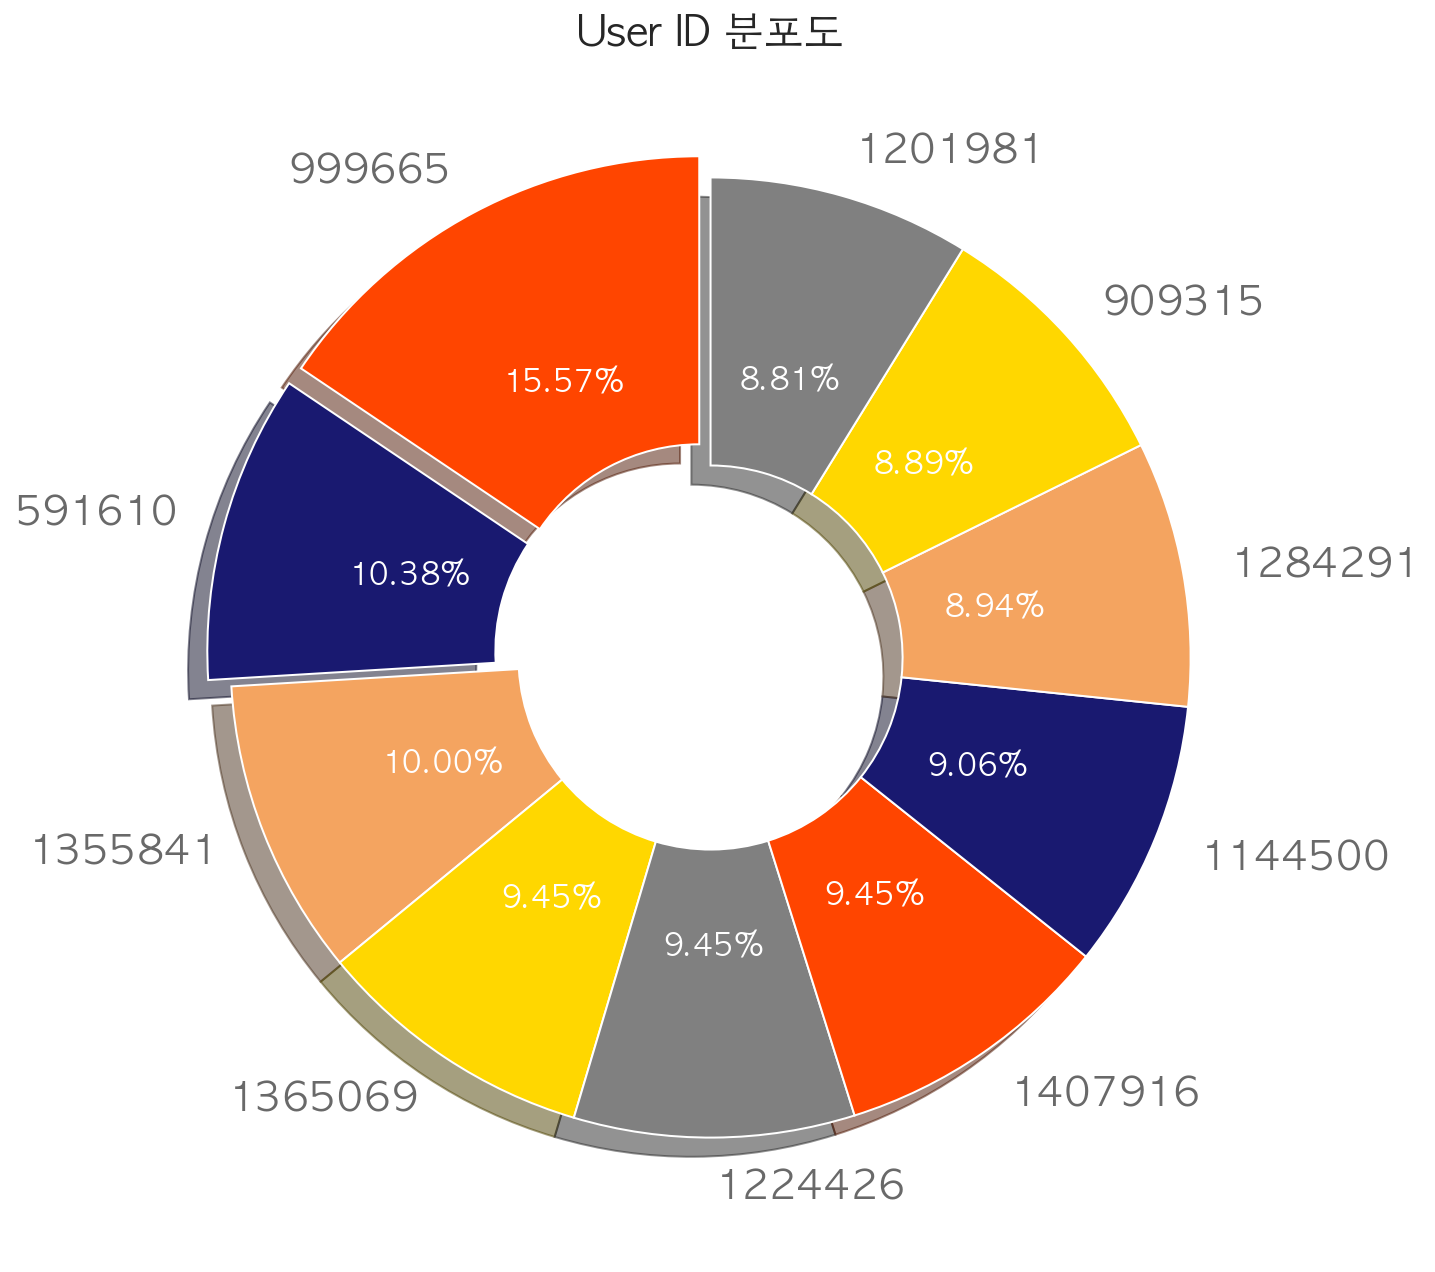

In [36]:
# User ID Top 10개 그리기
labels = list(user_id['USER_ID'][:10].keys())## 라벨
frequency = list(user_id['USER_ID'][:10].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gold', 'gray', 'orangered','midnightblue',
          'sandybrown', 'gold', 'gray']  
plt.title("User ID 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- USER ID 중 999665이 가장 높게 나왔다.

In [37]:
# 매일 사용내역이 여러건 조회됨
df_db[df_db['USER_ID'] == 999665]

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,JOIN_DAY,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,PAY_DAY,WEEKDAY,COUNT,AD1
372,999665,2018-12-16,2018,12,16,CC,82399,A,2020-01-01,2020,1,1,Wed,6,JRR
1527,999665,2018-12-16,2018,12,16,CC,104988,A,2020-01-02,2020,1,2,Thu,11,GN
3121,999665,2018-12-16,2018,12,16,CC,181832,A,2020-01-03,2020,1,3,Fri,7,SC
5034,999665,2018-12-16,2018,12,16,CC,109223,A,2020-01-04,2020,1,4,Sat,28,MP
6919,999665,2018-12-16,2018,12,16,CC,104916,A,2020-01-05,2020,1,5,Sun,14,GN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,2018,12,16,CC,2428,A,2020-12-27,2020,12,27,Sun,17,CY
868847,999665,2018-12-16,2018,12,16,CC,109267,A,2020-12-28,2020,12,28,Mon,24,J
871562,999665,2018-12-16,2018,12,16,CC,90193,C,2020-12-29,2020,12,29,Tue,23,GW
874317,999665,2018-12-16,2018,12,16,CC,220797,D,2020-12-30,2020,12,30,Wed,40,GS


- 999665 ID를 제거하니 가장 높게 나온 ID 591610 이다

### 2-3. D_TYPE

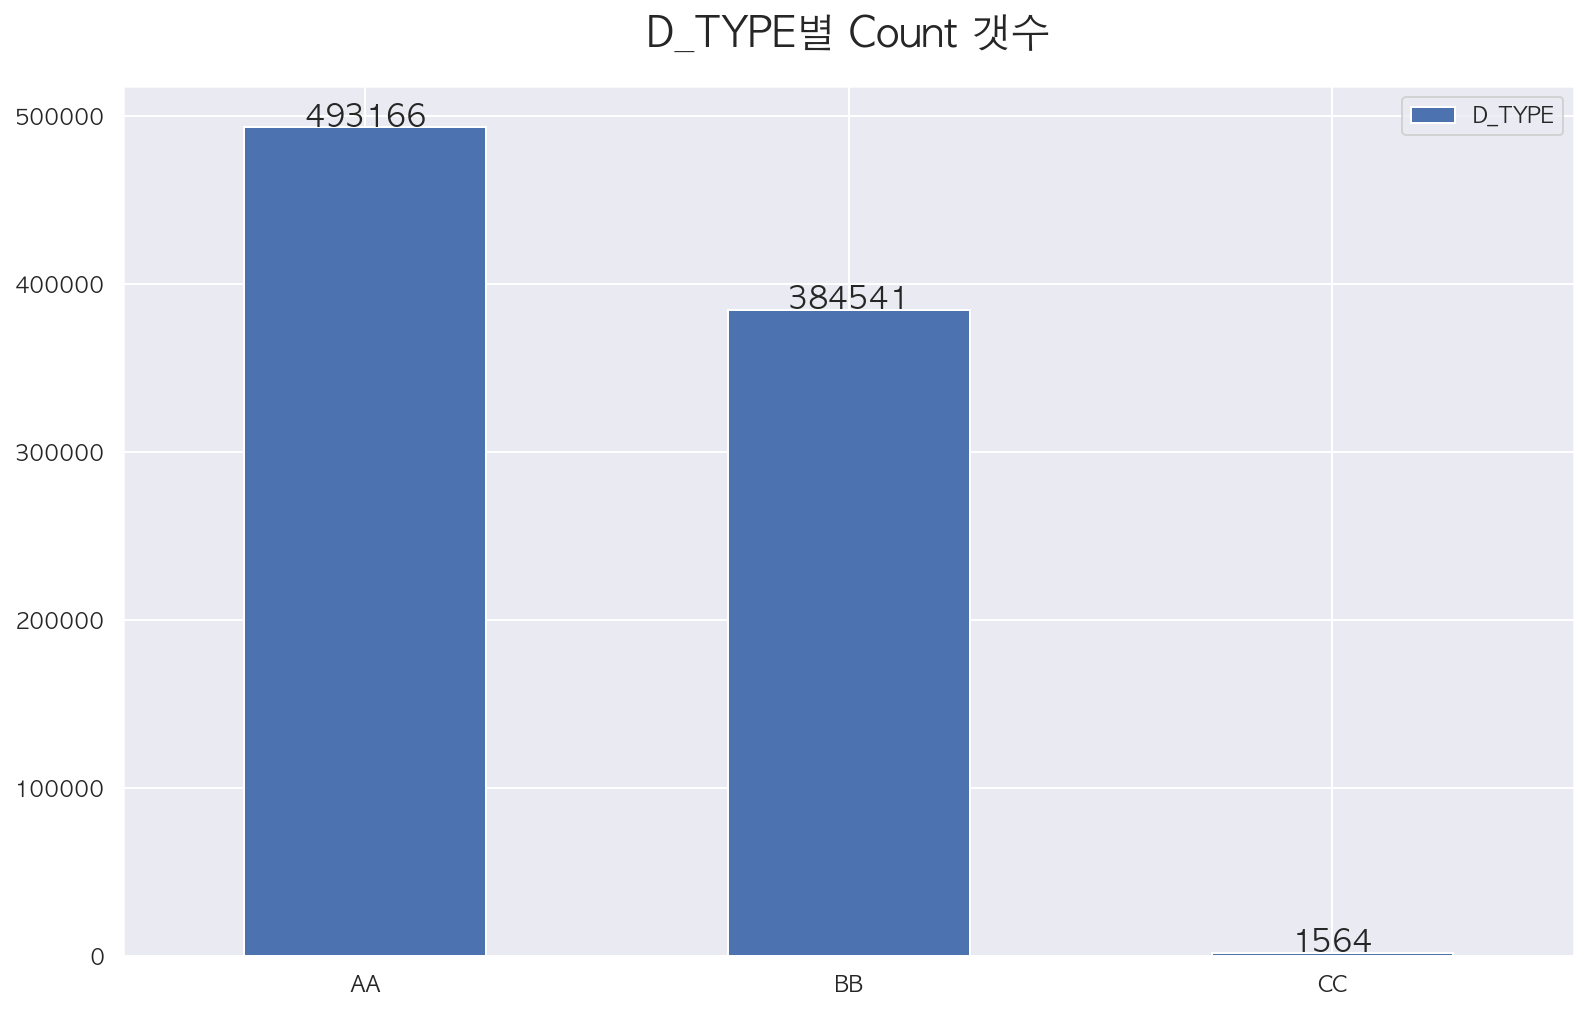

In [38]:
# D_TYPE별 count 개수 
count_by_types = pd.DataFrame(df_db['D_TYPE'].value_counts())

count_by_types.plot(kind = 'bar', figsize= (13, 8), rot = 0)
plt.title("D_TYPE별 Count 갯수",  fontsize = 20, pad=20)
order2 = df_db['D_TYPE'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt = count
    plt.text(i, count+700, strt, ha = "center", fontsize=15)

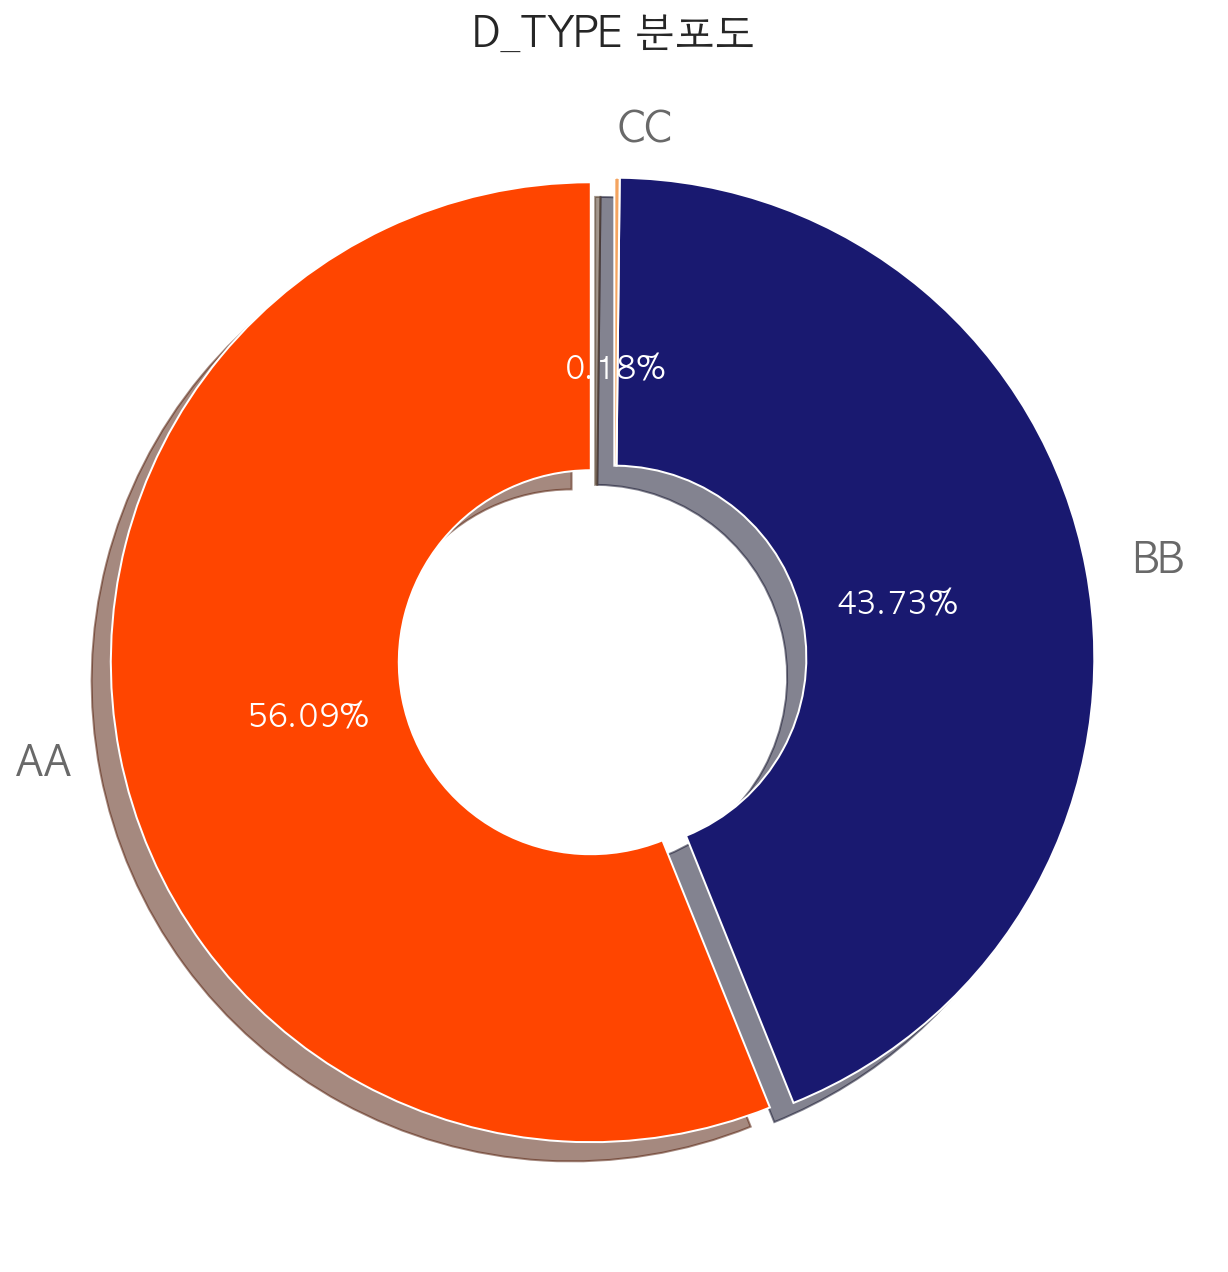

In [39]:
d_type = pd.DataFrame(df_db['D_TYPE'].value_counts())

labels = list(d_type['D_TYPE'][:].keys())## 라벨
frequency = list(d_type['D_TYPE'][:].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown']  
plt.title("D_TYPE 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- AA: 56.09%(493,166건), BB: 43.73%(384,541건), CC: 0.18%(471건) 가장 많은 것으로 나타냈다.

### 2-4. Store_ID

In [40]:
store_id = pd.DataFrame(df_db['STORE_ID'].value_counts())
store_id.head(20)

,STORE_ID
220557,17617
220893,17220
220655,16275
220848,15935
92437,15866
105033,15020
91853,14605
1109,14053
82400,12298
109037,12200


In [41]:
print("고유 Store ID는", len(store_id),"건 입니다.")

고유 Store ID는 1061 건 입니다.


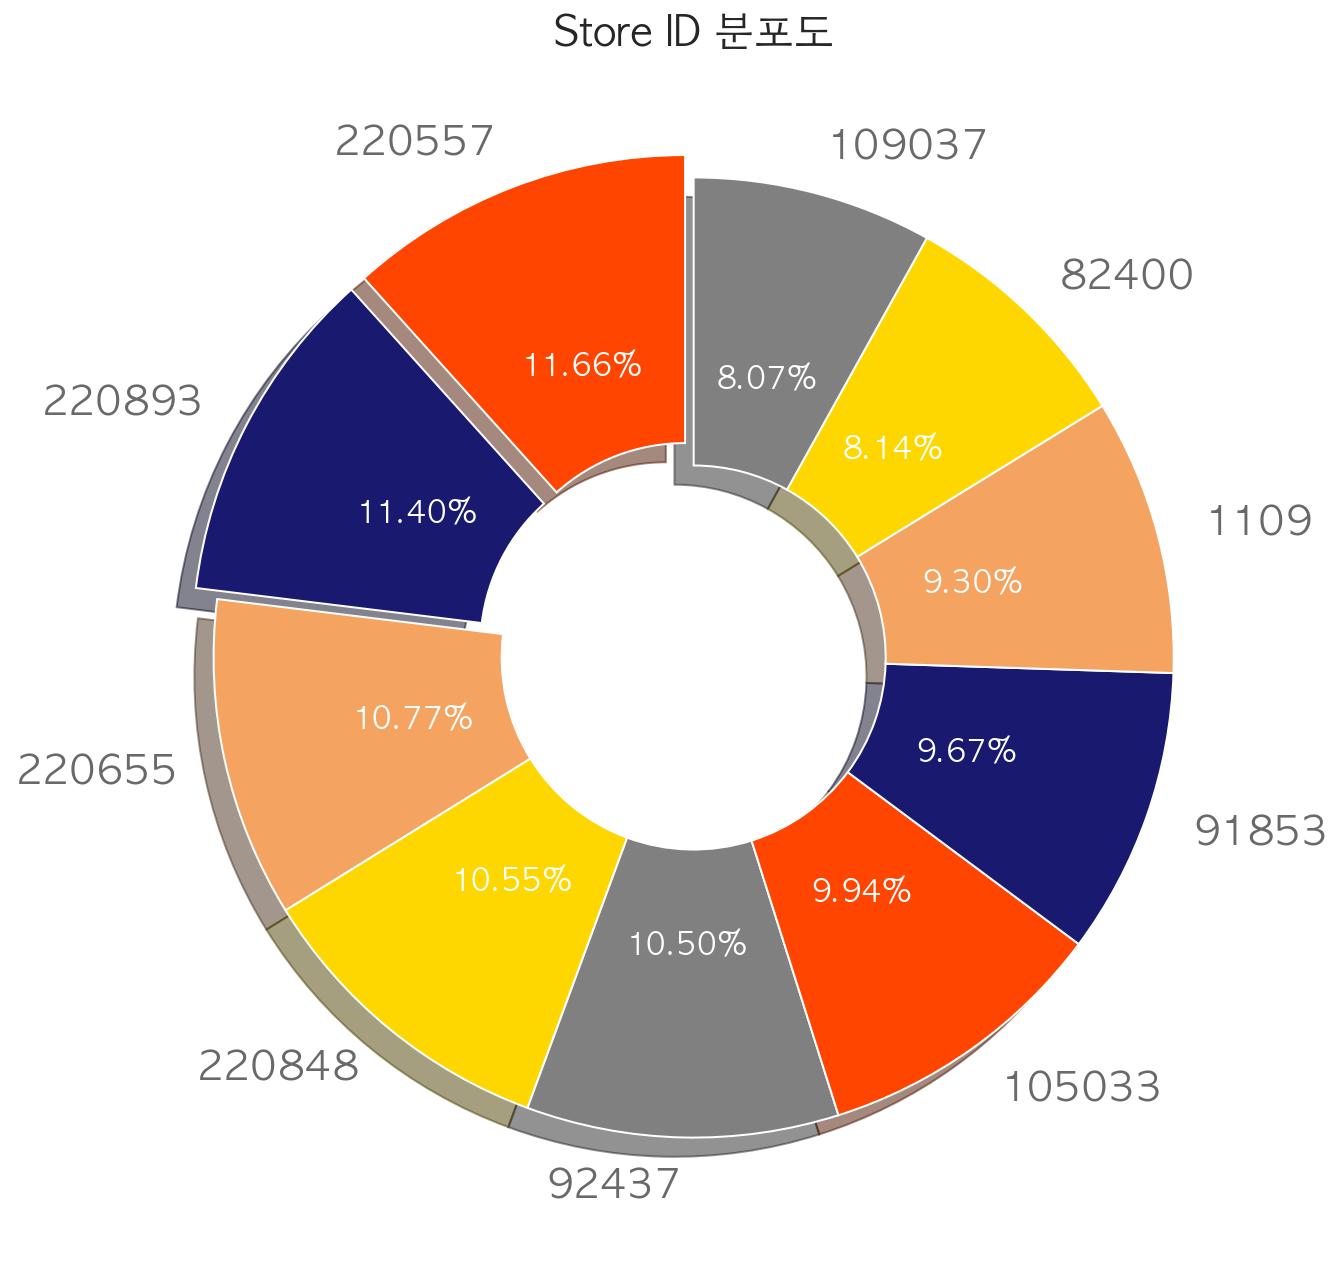

In [42]:
# Store ID Top 10개 그리기
labels = list(store_id['STORE_ID'][:10].keys())## 라벨
frequency = list(store_id['STORE_ID'][:10].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gold', 'gray', 'orangered','midnightblue',
          'sandybrown', 'gold', 'gray']  
plt.title("Store ID 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- Store ID 분포를 살펴보니 220557과 220893의 건수가 가장 많았다.

### 2-5. GOODS_TYPE

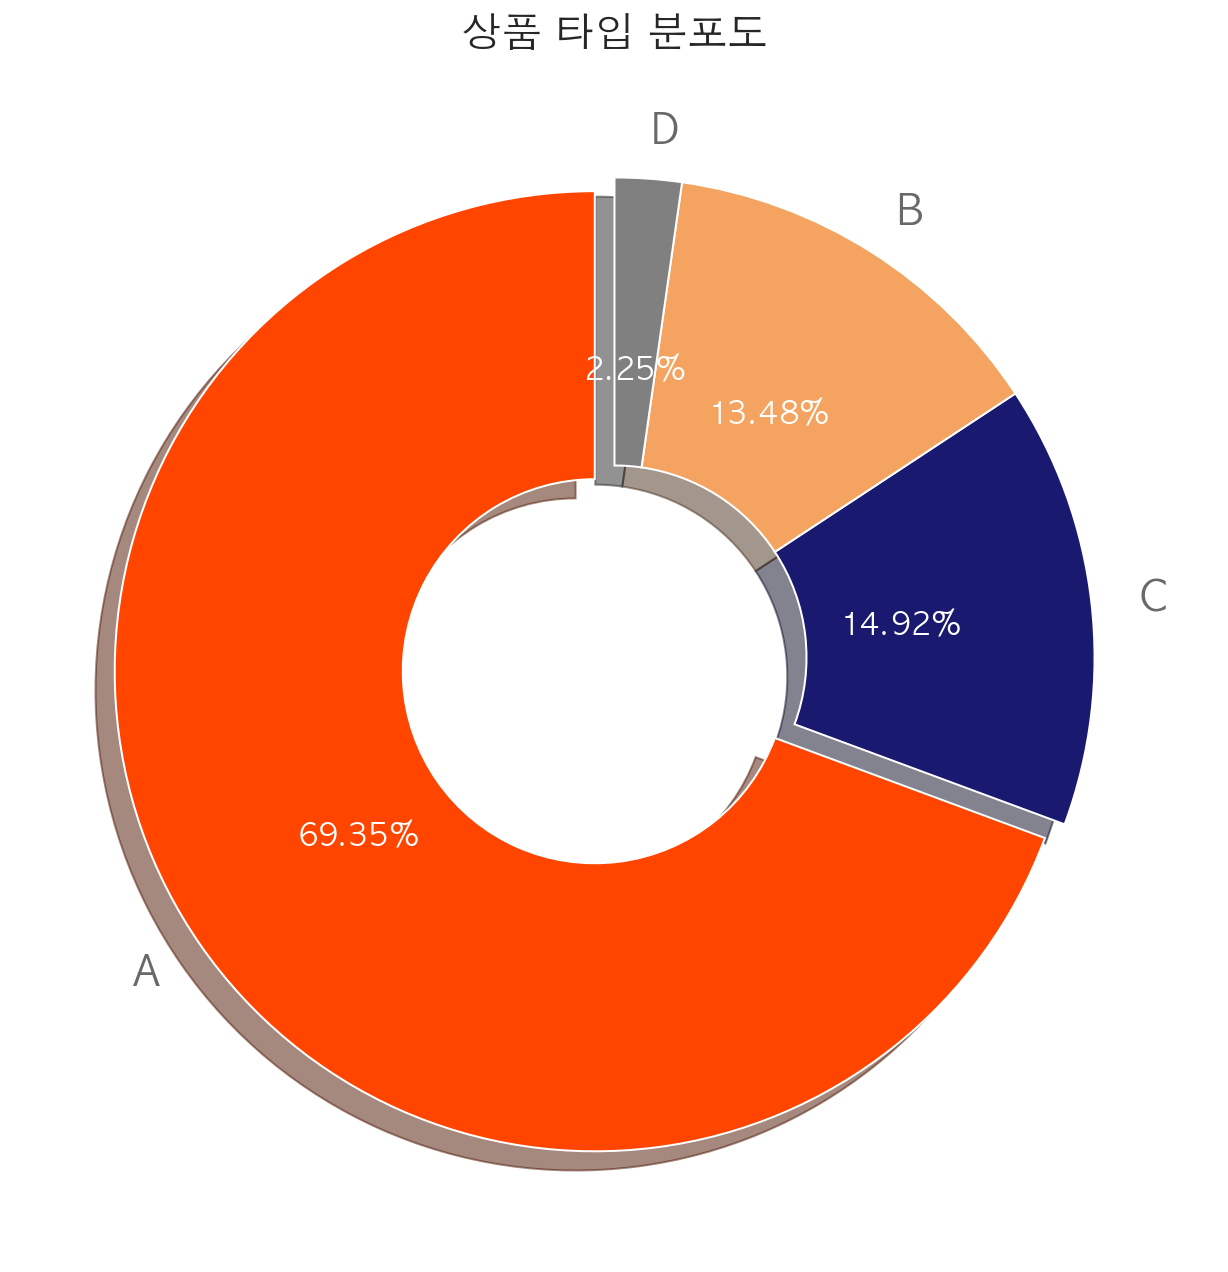

In [43]:
good_type = pd.DataFrame(df_db['GOODS_TYPE'].value_counts())

labels = list(good_type['GOODS_TYPE'][:].keys())## 라벨
frequency = list(good_type['GOODS_TYPE'][:].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gray']  
plt.title("상품 타입 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

### 2-6. 결제일 관련 데이터  

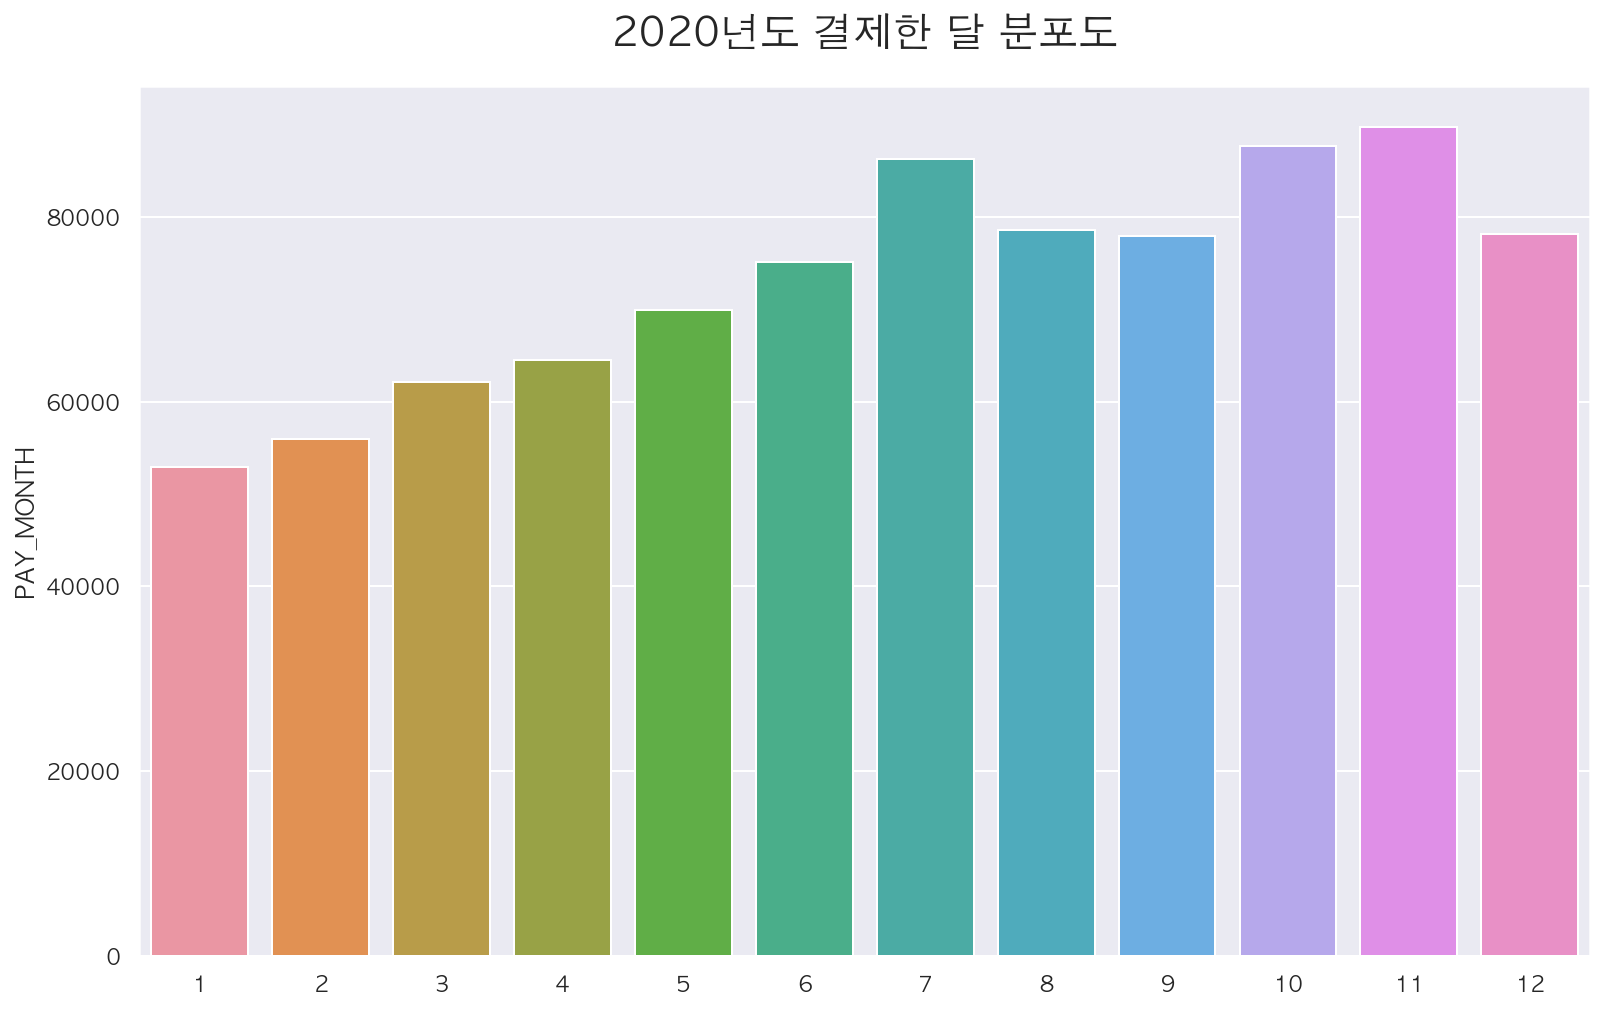

In [44]:
pay_month = pd.DataFrame(df_db['PAY_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2020년도 결제한 달 분포도", fontsize=20, pad=20)
sns.barplot(data=pay_month, x=pay_month.index, y="PAY_MONTH")
plt.show()

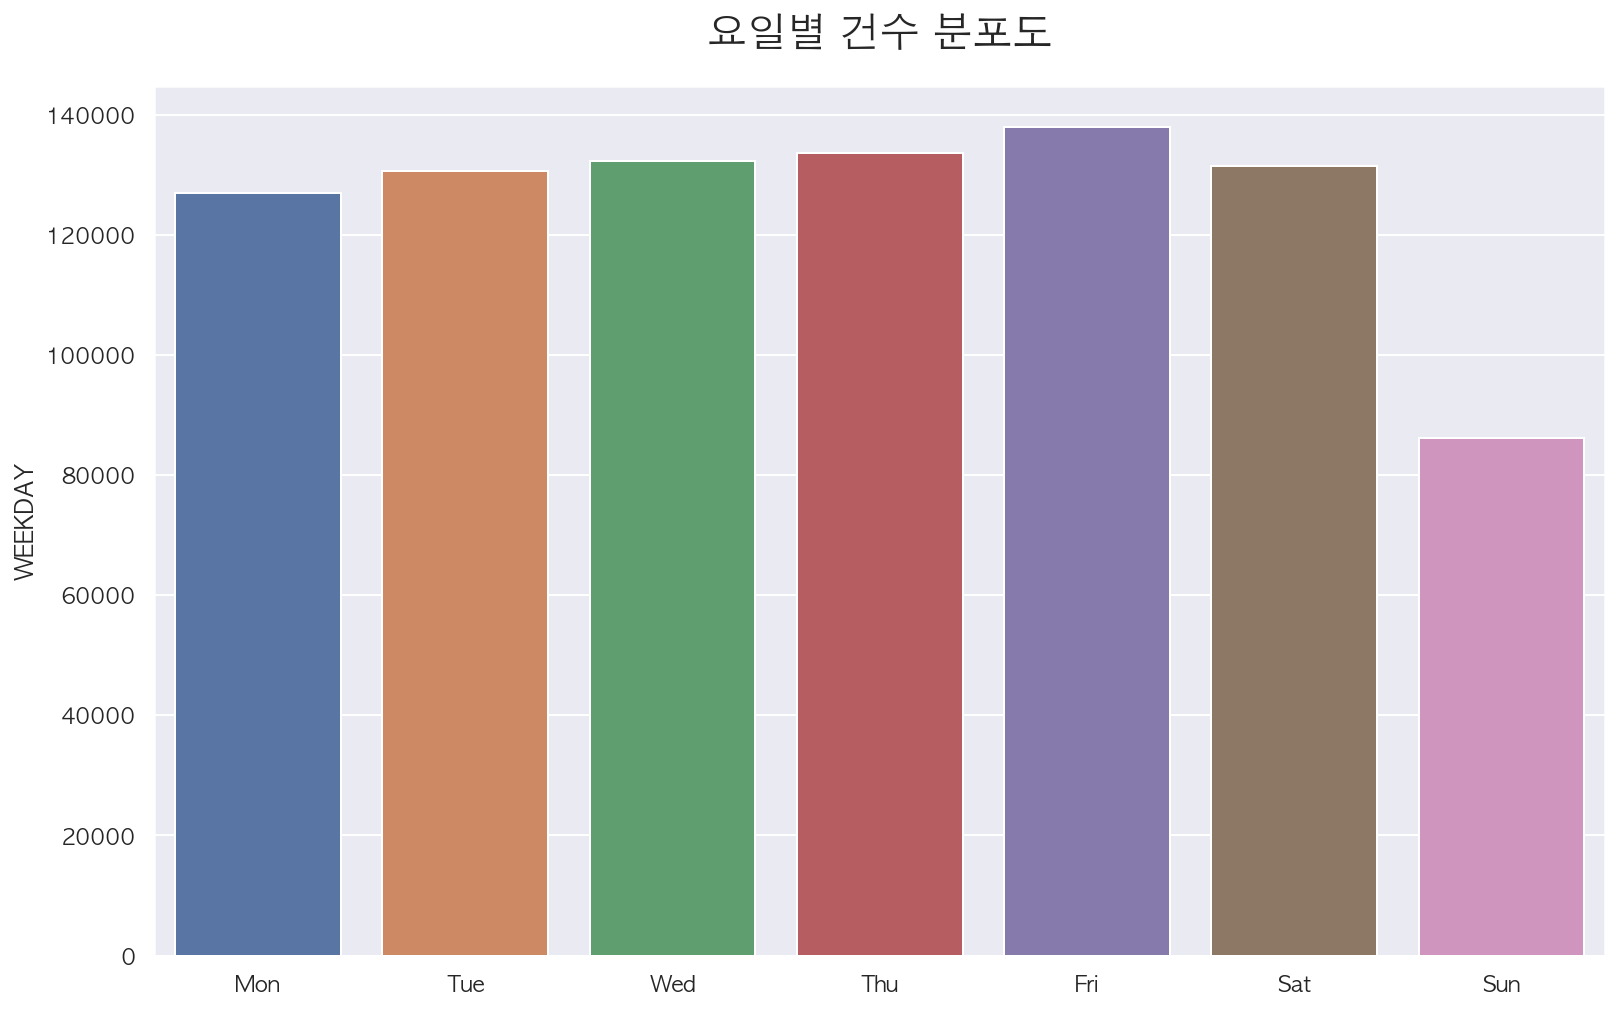

In [46]:
# 요일별 data 건수 
week = pd.DataFrame(df_db['WEEKDAY'].value_counts())
plt.figure(figsize=(13, 8))
plt.title("요일별 건수 분포도", fontsize=20, pad=20)
sns.barplot(x = week.index, y = week['WEEKDAY'], order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

- 해당 데이터의 결제일을 보면 모두 2020년도 자료만 존재한다.
- 결제달을 분석해보니 가장 많은 달은 11월과 7월 이다.
- 요일 컬럼을 추가하여 요일별로 살펴본 결과 월요일부터 금요일까지 이용량이 많고, 용량이 증가추이를 보이다가 주말인 토요일과 일요일 감소하는 것으로 나타냄

### 2-7. 결제 건수

In [47]:
count = pd.DataFrame(df_db['COUNT'].value_counts().sort_index())
count.head()

,COUNT
1,863775
2,13519
3,1061
4,271
5,136


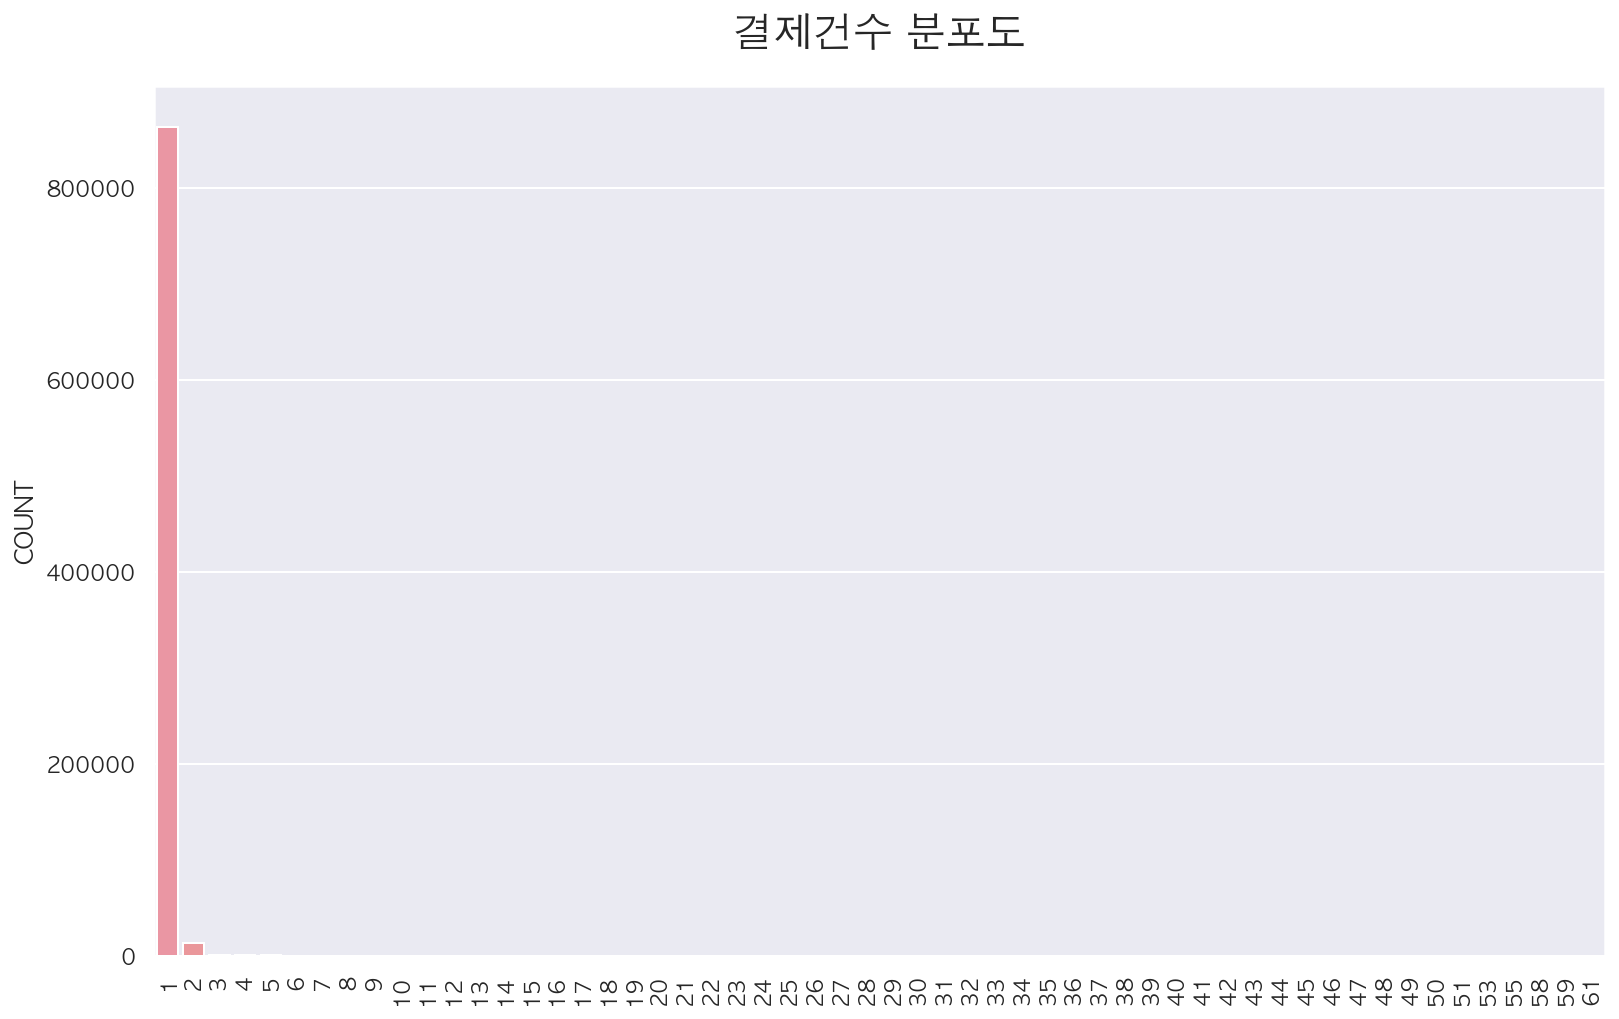

In [48]:
# 결제건수 분포도 
plt.figure(figsize=(13, 8))
plt.title("결제건수 분포도", fontsize=20, pad=20)
plt.xticks(rotation = 90)
sns.barplot(x = count.index, y = count['COUNT']);

- 결제건수는 1건이 가장 많긴 하지만, 다양한 유형의 결제건수가 함께 존재함을 확인하였다.

### 2-8. AD1

In [49]:
ad = pd.DataFrame(df_db['AD1'].value_counts())
ad.index.unique

<bound method Index.unique of Index(['J', 'GN', 'JRR', 'SC', 'MP', 'YD', 'YO', 'GS', 'CY', 'BF', 'GJ', 'SD',
       'CD', 'GW', 'DM', 'GD', 'P', '0', 'DJ', 'GSN', 'Q', 'GBC', 'SOD', 'YC',
       'BJG', 'NO', 'SB', 'GB', 'R', 'WT', 'GGY', 'ZE', 'WF', 'GSW', 'JR',
       'GHN', 'BOI', 'GAY', 'IND', 'GGM', 'COI', 'SG', 'GEJ', 'GAS', 'GKP',
       'BHW', 'BUD', 'GYI', 'DB', 'GPJ', 'ABP', 'SOI', 'PJP', 'CCA', 'BI',
       'DIV', 'AOI', 'IYS', 'BO', 'CN', 'SJV', 'BP', 'CAS', 'VU', 'DOI', 'ZP',
       'SDU', 'QH', 'WH', 'QGI', 'DSO', 'GGC', 'EP', 'CU', 'CVB', 'X', 'WOID',
       'WAE', 'SP', 'RRR', 'NW', 'ADS', 'GR', 'DY', 'VO'],
      dtype='object')>

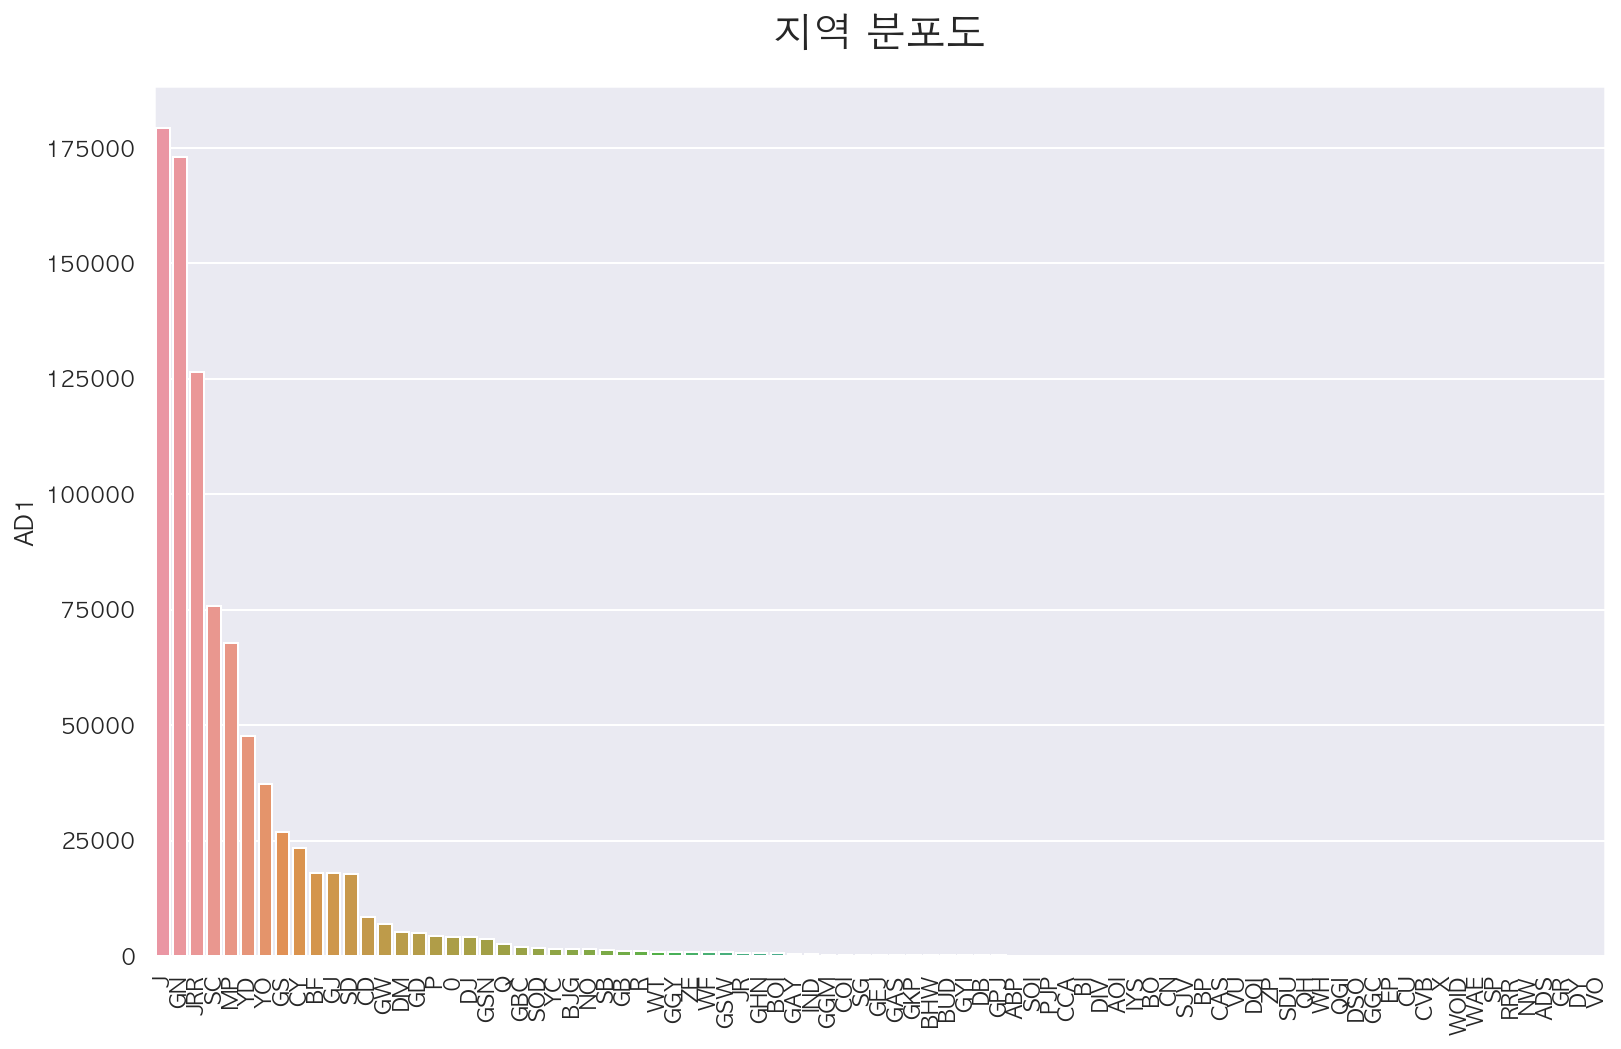

In [50]:
# 전체 지역 분포도 
plt.figure(figsize=(13, 8))
plt.title("지역 분포도", fontsize=20, pad=20)
plt.xticks(rotation = 90)
sns.barplot(x = ad.index, y = ad['AD1']);

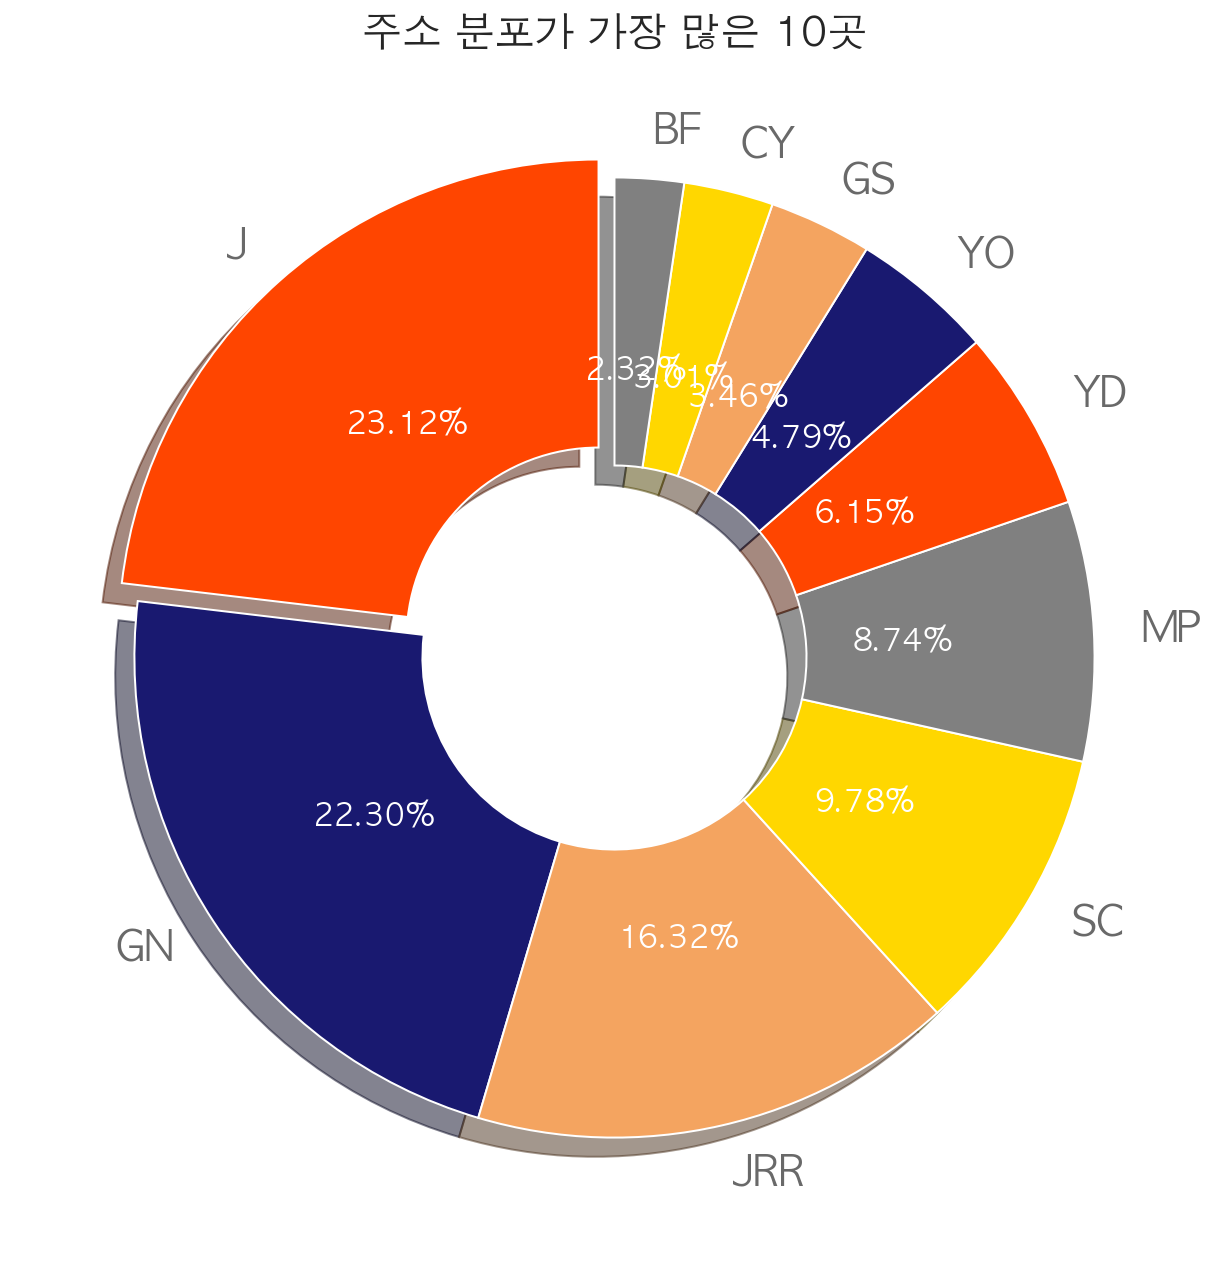

In [51]:
# 주소 분포가 가장 많은 10곳 
labels = list(ad['AD1'][:10].keys())## 라벨
frequency = list(ad['AD1'][:10].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gold', 'gray', 'orangered','midnightblue',
          'sandybrown', 'gold', 'gray']  
plt.title("주소 분포가 가장 많은 10곳", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- 가장 많은 지역은 'J'지역 이다 

###  첫 번째 EDA 결과 
1. 가입일을 분석해보니 가입자수는 꾸준히 증가하고 있는 것으로 보여진다. 특히 가장 많은 증가율을 가진 구간은 144% 증가폭을 가진 2016년 ~ 2017년 이다.
2. 그러나 가입일에 1970년도의 자료가 있다. 자료를 살펴보니 모든 가입일이 1970년 1월 1일로 나타내어 이상치로 판단된다 (해당 데이터 Drop 결정)
3. User_ID는 999665의 ID가 가장 언급이 많았다, 결제일도 살펴 보니 매일 사용 내역이 존재한다. 혹시 마스터 ID라 생각이 든다. (해당 데이터도 의미가 있는 데이터가 아님을 결정하여 Drop 결정)
4. D_TYPE은 AA 타입이 56.09%(493,166건)으로 가장 많았다. 해당 데이터의 정보가 없어 모두의 주차장 어플, 모두의 주차장과 관련된 뉴스, 서울시 자료 등 조사해보았지만 정보가 나오지 않았다.
5. Store ID 분포를 살펴보니 220557과 220893의 건수가 가장 많았다. 아마 모두의 주차장을 통해 가장 많이 사용되는 주차장일 것으로 판단된다.(민영 주차장)
6. GOODS TYPE을 살펴 보니 A 타입이 앞도적으로 가장 많았다. 컬럼의 명을 비춰보아 왠지 결제시 사용하는 이용권(평일주중권, 평일야간권, 공휴일주중권, 공휴일야간권) 혹은 주차장의 종류(부설, 민영, 공영, 공유)로 추측해본다.
7. 결제일 데이터에서 파악된 것은 년도는 2020년도 결제일의 데이터만 존제하며, 가장 많은 결제가 이뤄진 달은 연말 11월, 결제가 가장 많이 이뤄진 요일은 예상외로 주중인 금요일이었다.
8. 결제건수는 1건이상이 많은 것을 보아 최소 가입하고 1번 이상은 사용한 것으로 보인다.
9. AD1의 컬럼을 살펴보니 이니셜이 있었다. 다른 외부데이터들의 기준이 서울시 임을 미뤄보아 해당 데이터는 서울 행정구의 이니셜인 듯 하다. (즉 해당 데이터는 주소 데이터가 되겠다)
10. 가장 많이 언급된 지역은 J, GN 즉 중구와 강남으로 파악된다. (서울시에서 주관한 모두의 주차장 성과 프레젠테이션 자료를 보아 두 지역의 주차난이 가장 심각했다.)

### 해당 EDA의 결과를 바탕으로 Feature Enineering과 모델링 작업 진행 예정 

In [54]:
# feature 작업과 모델링을 위해 사전 전치리한 데이터 csv 파일로 저장
df_db.to_csv('data/moduparkingDB.csv', index=False)